In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import PathPatch

import seaborn as sns
import scanpy as sc
import pandas as pd
import decoupler as dc
import sys
import ast
import functools
import neptune

In [2]:
working_dir = '/home/acollin/scPermut/'
fig_dir = '/home/acollin/scPermut/analysis_notebooks/figures/'

In [3]:
import os
os.chdir(working_dir)

In [4]:
sys.path.append(working_dir)

In [5]:
from scpermut.tools.clust_compute import nn_overlap, batch_entropy_mixing_score,lisi_avg, balanced_matthews_corrcoef, balanced_f1_score, balanced_cohen_kappa_score

from sklearn.metrics import accuracy_score,balanced_accuracy_score,matthews_corrcoef, f1_score,cohen_kappa_score, adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score,davies_bouldin_score,adjusted_rand_score,confusion_matrix
f1_score = functools.partial(f1_score, average = 'macro')


In [6]:
from scpermut.workflow.dataset import load_dataset
from scpermut.tools.utils import ann_subset, check_raw,save_json, load_json, rgb2hex,hex2rgb,load_expe

/home/acollin/scPermut/analysis_notebooks


In [7]:
def load_expe(neptune_id, working_dir):
    save_dir = result_dir(neptune_id, working_dir)
    X = load_latent_space(neptune_id, working_dir)
    pred = load_pred(neptune_id, working_dir)
    adata = sc.AnnData(X = X, obs = pred)
    # proba_pred = load_proba_pred(neptune_id, working_dir)
    umap = load_umap(neptune_id, working_dir)
    # adata.obsm['proba_pred'] = proba_pred
    adata.obsm['X_umap'] = umap
    return adata


In [8]:
# for ta in ['task_2', 'task_3']:
#     run = neptune.init_run(
#                         project="becavin-lab/benchmark",
#                         api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRkMWRjNS03ZGUwLTQ1MzQtYTViOS0yNTQ3MThlY2Q5NzUifQ==",
#     )
#     run[f"parameters/task"] = ta
#     run[f"parameters/debug_status"] = "fixed_1"
#     run.stop()

In [9]:
def load_run_df(task):
    project = neptune.init_project(
            project="becavin-lab/benchmark",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRkMWRjNS03ZGUwLTQ1MzQtYTViOS0yNTQ3MThlY2Q5NzUifQ==",
        mode="read-only",
            )# For checkpoint

    runs_table_df = project.fetch_runs_table(query = f'`parameters/task`:string = "{task}"').to_pandas()
    project.stop()

    f =  lambda x : x.replace('evaluation/', '').replace('parameters/', '').replace('/', '_')
    runs_table_df.columns = np.array(list(map(f, runs_table_df.columns)))
    return runs_table_df

In [10]:
dataset_names = {'htap':'htap',
                "ajrccm_by_batch":"ajrccm_by_batch",
                'hlca_par_dataset_harmonized':'hlca_par_dataset_harmonized',
                'hlca_trac_dataset_harmonized':'hlca_trac_dataset_harmonized' ,
                'koenig_2022' : 'celltypist_dataset/koenig_2022/koenig_2022_healthy',
                'tosti_2021' : 'celltypist_dataset/tosti_2021/tosti_2021',
                'yoshida_2021' : 'celltypist_dataset/yoshida_2021/yoshida_2021',
                'tran_2021' : 'celltypist_dataset/tran_2021/tran_2021',
                'dominguez_2022_lymph' : 'celltypist_dataset/dominguez_2022/dominguez_2022_lymph',
                'dominguez_2022_spleen' : 'celltypist_dataset/dominguez_2022/dominguez_2022_spleen',
                'tabula_2022_spleen' : 'celltypist_dataset/tabula_2022/tabula_2022_spleen',
                'litvinukova_2020' : 'celltypist_dataset/litvinukova_2020/litvinukova_2020',
                 'lake_2021': 'celltypist_dataset/lake_2021/lake_2021'
                }

dataset_list = ['htap', 'yoshida_2021', 'hlca_trac_dataset_harmonized',
               'lake_2021', 'dominguez_2022_spleen', 'ajrccm_by_batch',
               'tosti_2021', 'tran_2021', 'litvinukova_2020','koenig_2022',
               'hlca_par_dataset_harmonized', 'dominguez_2022_lymph',
                'tabula_2022_spleen']


diff_dict = {'homo': ['tosti_2021', 'tran_2021', 'yoshida_2021', 'htap', 'ajrccm_by_batch'],
           'assays': ['dominguez_2022_lymph', 'dominguez_2022_spleen', 'tabula_2022_spleen'],
           'suspension': ['koenig_2022', 'litvinukova_2020', 'lake_2021'],
           'datasets': ['hlca_par_dataset_harmonized','hlca_trac_dataset_harmonized']}

aestetic_data_name = {'tosti_2021': 'Tosti 2021',
                      'tran_2021': 'Tran 2021', 
                      'yoshida_2021': 'Yoshida 2021',
                      'htap': 'Mbouamboua 2024', 
                      'ajrccm_by_batch': 'Deprez 2020',
                      'dominguez_2022_lymph': 'Dominguez 2022 - lymph',
                      'dominguez_2022_spleen': 'Dominguez 2022 - spleen',
                      'tabula_2022_spleen': 'Tabula Sapiens - spleen',
                      'koenig_2022': 'Koenig 2022', 
                      'litvinukova_2020': 'Litvinukova 2020', 
                      'lake_2021': 'Lake 2021',
                      'hlca_par_dataset_harmonized': 'HLCA - Parenchyma',
                      'hlca_trac_dataset_harmonized': 'HLCA - Airway'}



aestetic_model_name = {'scPermut' : 'scMusketeers',
                       'scPermut_default' : 'scMusketeers - default',
                      'scanvi' : 'scANVI',
                       'uce' : 'UCE', 
                       'harmony_svm' : 'Harmony',
                      'pca_svm' : 'PCA',
                       'celltypist' : 'Celltypist',
                       'scmap_cells' : 'scmap - cells',
                       'scmap_cluster' : 'scmap - cluster'}

hp_list=['use_hvg',
'batch_size',
'clas_w',
'dann_w',
'rec_w',
'ae_bottleneck_activation',
         'clas_loss_name',
'size_factor',
'weight_decay',
'learning_rate',
'warmup_epoch',
'dropout',
'layer1',
'layer2',
'bottleneck',
        'training_scheme']



# Fig 5 - subset on percentage of dataset

In [77]:
runs_table_df = load_run_df(task = "task_2")

[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/becavin-lab/benchmark/


Fetching table...: 0 [00:00, ?/s]

[neptune] [info   ] Shutting down background jobs, please wait a moment...
[neptune] [info   ] Done!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/becavin-lab/benchmark/metadata


In [78]:
test_fold_selection = load_json(working_dir + 'experiment_script/benchmark/hp_test_folds')
test_obs = load_json(working_dir + 'experiment_script/benchmark/hp_test_obs')

In [79]:
runs_table_df.query("task == 'task_2'").query('model == "scPermut"')['dataset_name'].value_counts()

koenig_2022                     48
tabula_2022_spleen              48
dominguez_2022_lymph            48
litvinukova_2020                42
hlca_par_dataset_harmonized     33
htap                            24
lake_2021                       24
tosti_2021                      24
dominguez_2022_spleen           24
hlca_trac_dataset_harmonized    24
ajrccm_by_batch                 24
yoshida_2021                    24
tran_2021                       24
Name: dataset_name, dtype: int64

In [88]:
# Remove duplicate experiments

drop_koe = runs_table_df.loc[(runs_table_df['debug_status'] != 'fixed_1') & (runs_table_df['dataset_name'] == 'koenig_2022') & (runs_table_df['model'] == 'scPermut')]
drop_tab = runs_table_df.loc[(runs_table_df['debug_status'] != 'fixed_1') & (runs_table_df['dataset_name'] == 'tabula_2022_spleen') & (runs_table_df['model'] == 'scPermut')]
drop_dom = runs_table_df.loc[(runs_table_df['debug_status'] != 'fixed_1') & (runs_table_df['dataset_name'] == 'dominguez_2022_lymph') & (runs_table_df['model'] == 'scPermut')]

drop_lit = runs_table_df.loc[(runs_table_df['debug_status'] == 'fixed_1') & (runs_table_df['dataset_name'] == 'litvinukova_2020') & (runs_table_df['model'] == 'scPermut')]
drop_par = runs_table_df.loc[(runs_table_df['debug_status'] == 'fixed_1') & (runs_table_df['dataset_name'] == 'hlca_par_dataset_harmonized') & (runs_table_df['model'] == 'scPermut')]




runs_table_df = runs_table_df.drop(drop_koe.index).drop(drop_tab.index).drop(drop_dom.index).drop(drop_lit.index).drop(drop_par.index)

In [89]:
colors = {'scPermut':"#B15236",
          # 'scPermut_default' : "#B15240",
          'scanvi':"#C78C3B" ,
          'uce':"#D3A53C" ,
          'harmony_svm': "#5B9DC7",
          'pca_svm':"#264D74",
          # 'pca_knn':"#264D80",
          'celltypist': "#75BAD3",
          'scmap_cells':"#607F6A" ,
          'scmap_cluster':"#707C45"}

colors = {aestetic_model_name[k]: v for k, v in colors.items()}

col = [hex2rgb(i) for i in colors.values()]
split = 'test'
met = 'balanced_acc'


In [ ]:
dataset_name = 'dominguez_2022_spleen'
task_2 = runs_table_df.query("task == 'task_2'").query(f"dataset_name == '{dataset_name}'").query(f"test_fold_nb == {test_fold_selection[dataset_name]}").query('pct_split == 0.05')

In [15]:
diff_dict = {'all12':['tosti_2021',
  # 'tran_2021',
  'yoshida_2021',
  'htap',
  'ajrccm_by_batch', 
    'dominguez_2022_lymph',
  ],
'all22': ['dominguez_2022_spleen','tabula_2022_spleen',
                    'koenig_2022', 'litvinukova_2020', 'lake_2021',
                    'hlca_par_dataset_harmonized', 'hlca_trac_dataset_harmonized']}

In [104]:
aestetic_model_name = {'scPermut' : '1.scMusketeers',
                        'scanvi' : '2.scANVI',
                       'uce' : '3.UCE', 
                       'harmony_svm' : '4.Harmony',
                       'pca_svm' : '5.PCA',
                        'celltypist' : '6.Celltypist',
                       'scmap_cells' : '7.scmap - cells',
                       'scmap_cluster' : '8.scmap - cluster'}
abridged_model_name = {'scPermut' : '1',
                        'scanvi' : '2',
                       'uce' : '3', 
                       'harmony_svm' : '4',
                       'pca_svm' : '5',
                        'celltypist' : '6',
                       'scmap_cells' : '7',
                       'scmap_cluster' : '8'}

colors = {
          'scPermut' : "#B15240",
          'scanvi':"#C78C3B" ,
          'uce':"#D3A53C" ,
          'harmony_svm': "#5B9DC7",
          'pca_svm':"#264D74",
          # 'pca_knn':"#264D80",
          'celltypist': "#75BAD3",
          'scmap_cells':"#607F6A" ,
          'scmap_cluster':"#707C45"}

abridged_colors = {abridged_model_name[k]: v for k, v in colors.items()}
colors = {aestetic_model_name[k]: v for k, v in colors.items()}


diff_dict = {'all12':['tosti_2021',
  # 'tran_2021', # Removing Tran
  'yoshida_2021',
  'htap',
  'ajrccm_by_batch', 
    'dominguez_2022_lymph',
  'dominguez_2022_spleen'],
'all22': ['tabula_2022_spleen',
                    'koenig_2022', 'litvinukova_2020', 'lake_2021',
                    'hlca_par_dataset_harmonized', 'hlca_trac_dataset_harmonized']}

In [30]:
pct_ticks = {0.05:'5%', 0.1:'10%', 0.5:'50%', 0.9:'90%'}
pct_colors = {'5%':'white', '10%':'lightgrey', '50%':'grey', '90%':'black'}

ticks = {0.05:0,0.1:1,0.5:2,0.9:3}
n_ticks = len(ticks)

In [ ]:

# Créer une palette de dégradé de noir avec 5 tons
grey_palette = ['#f2f2f2', '#bfbfbf', '#808080', '#404040', '#000000']


patches = [Patch(facecolor=color, edgecolor='black', label=cat) for color, cat in zip(grey_palette, categories)]

# Ajouter une légende avec les patchs
ax.legend(handles=patches, title="Catégories", loc='upper left', fontsize=12, title_fontsize=14)

plt.show()
fig

##  Figure 5, hue = pct_split - Black & White 

In [91]:
test_fold_selection = load_json(working_dir + 'experiment_script/benchmark/hp_test_folds')
test_obs = load_json(working_dir + 'experiment_script/benchmark/hp_test_obs')

--------- all12 ---------
tosti_2021
Series([], Name: debug_status, dtype: int64)
yoshida_2021
Series([], Name: debug_status, dtype: int64)
htap
Series([], Name: debug_status, dtype: int64)
ajrccm_by_batch
Series([], Name: debug_status, dtype: int64)
dominguez_2022_lymph
fixed_1    24
Name: debug_status, dtype: int64
dominguez_2022_spleen
Series([], Name: debug_status, dtype: int64)
--------- all22 ---------
tabula_2022_spleen
fixed_1    24
Name: debug_status, dtype: int64
koenig_2022
fixed_1    24
Name: debug_status, dtype: int64
litvinukova_2020
Series([], Name: debug_status, dtype: int64)
lake_2021
Series([], Name: debug_status, dtype: int64)
hlca_par_dataset_harmonized
Series([], Name: debug_status, dtype: int64)
hlca_trac_dataset_harmonized
Series([], Name: debug_status, dtype: int64)


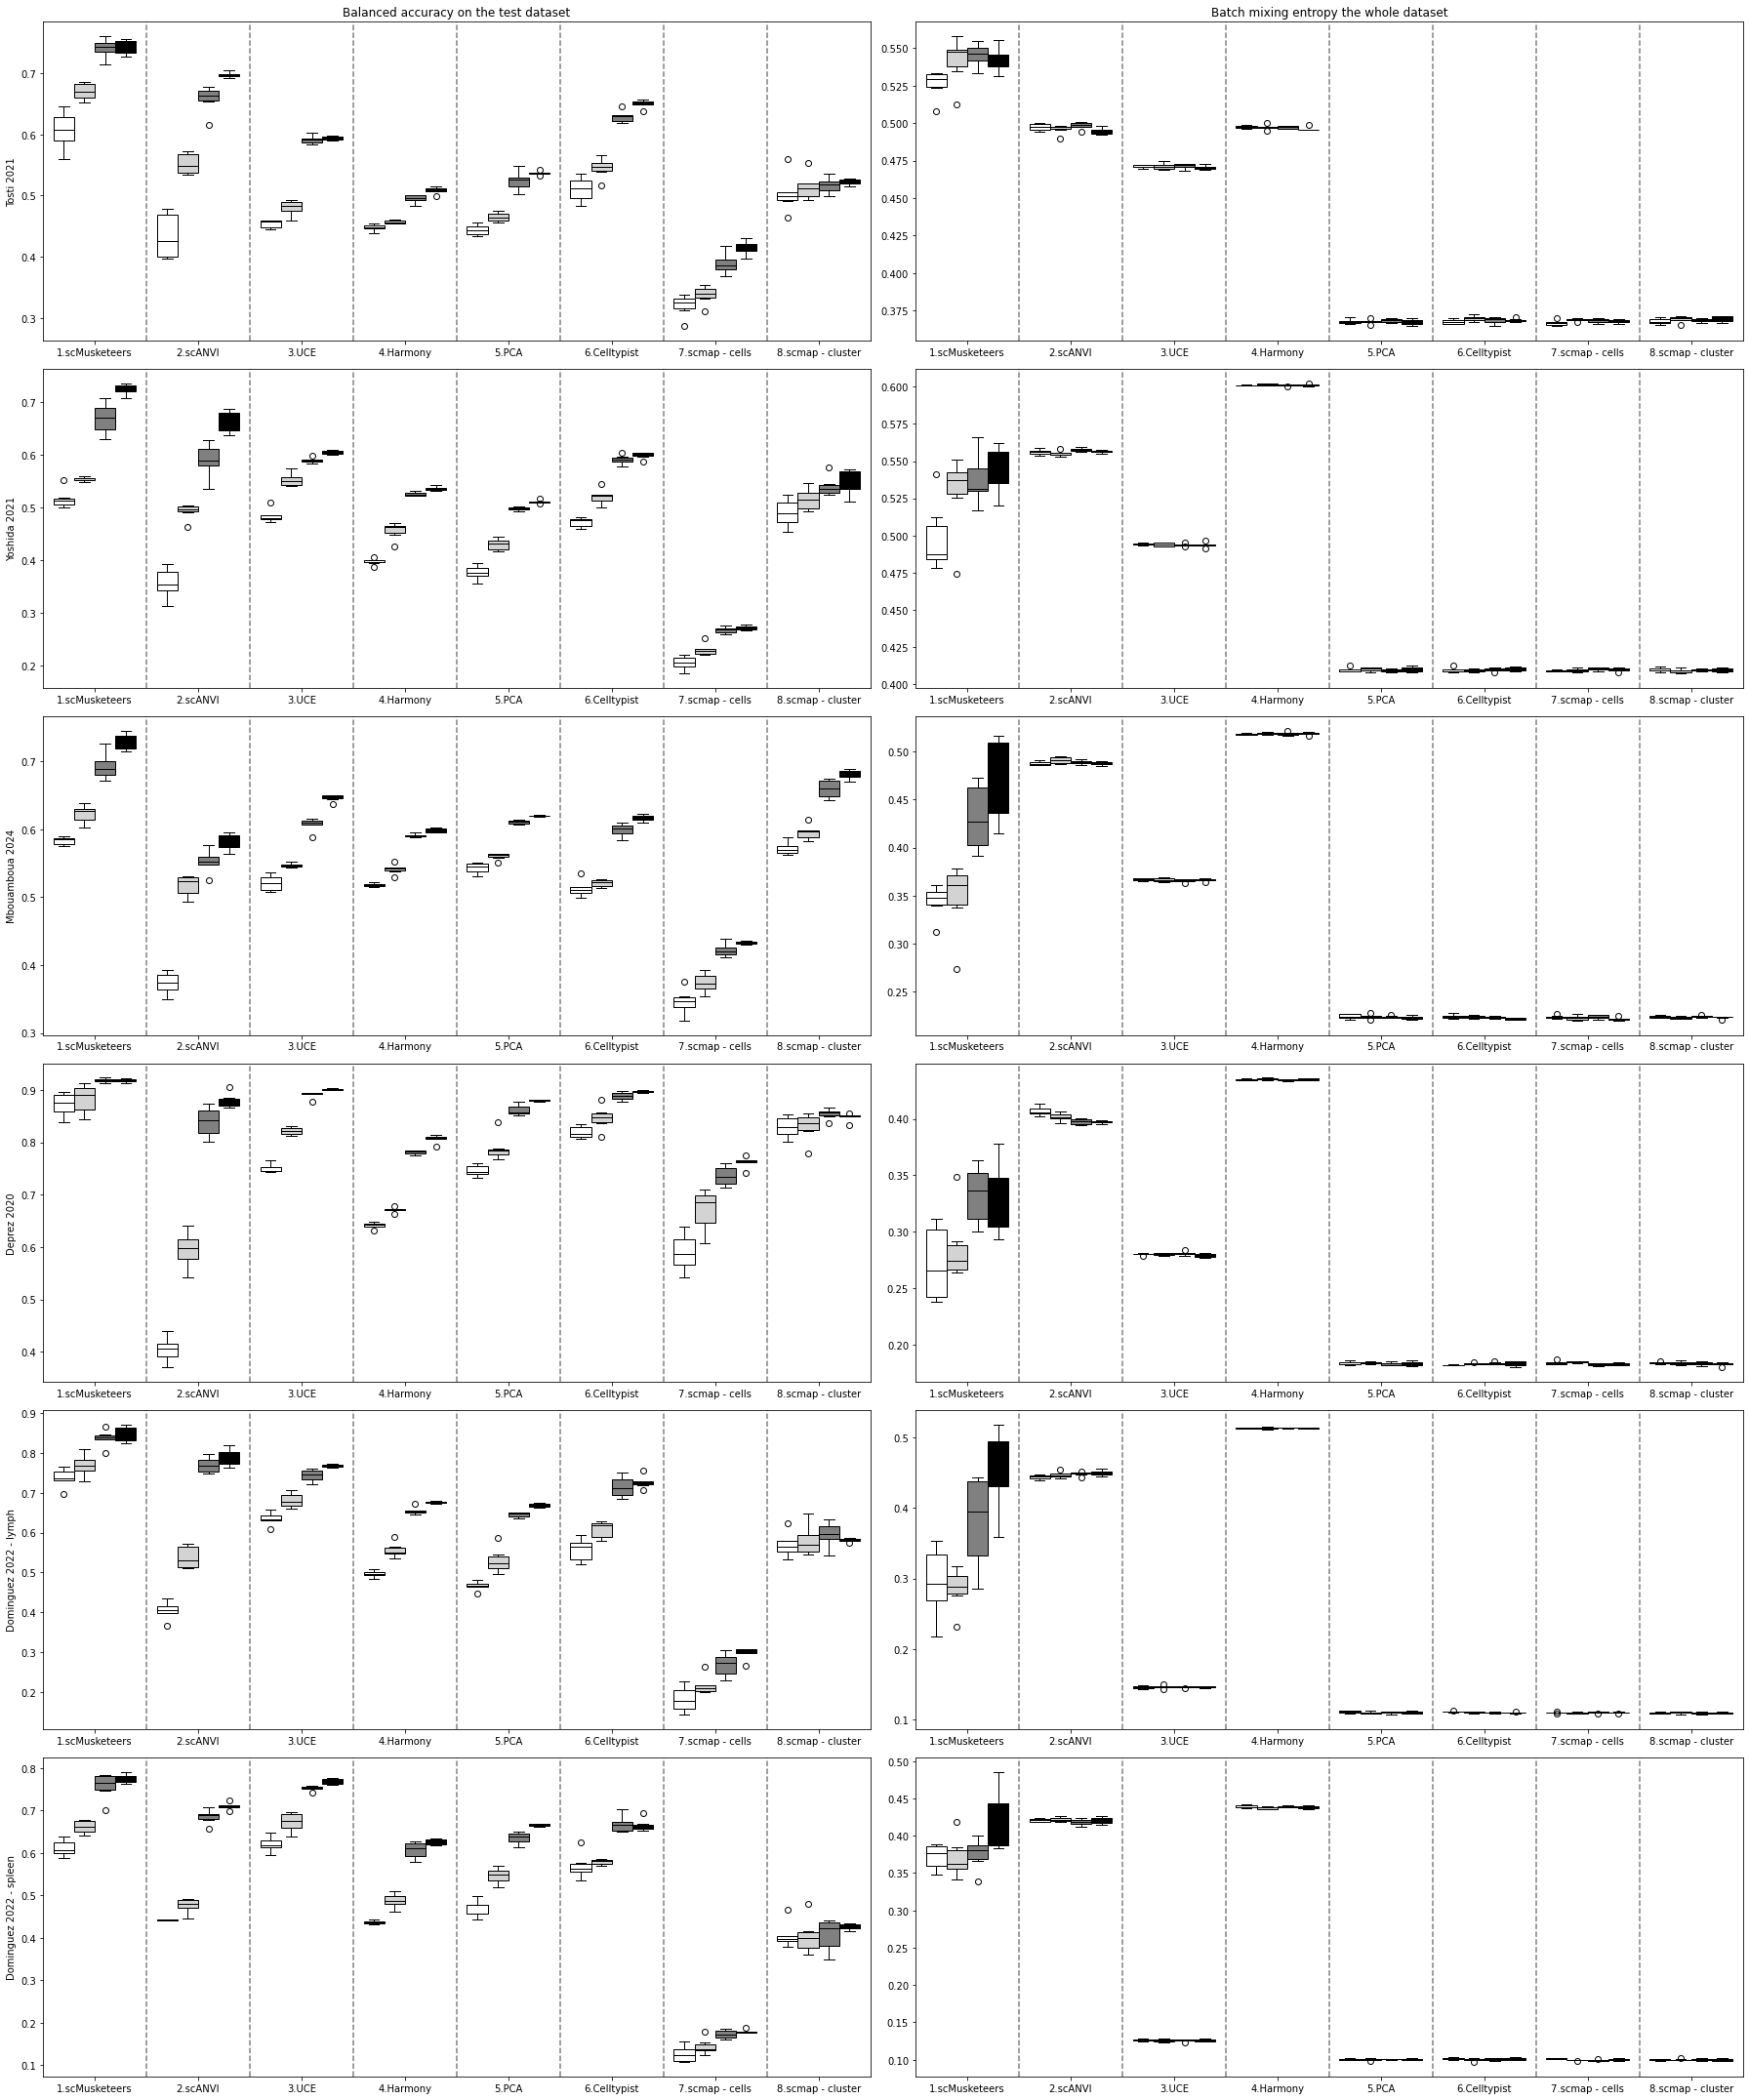

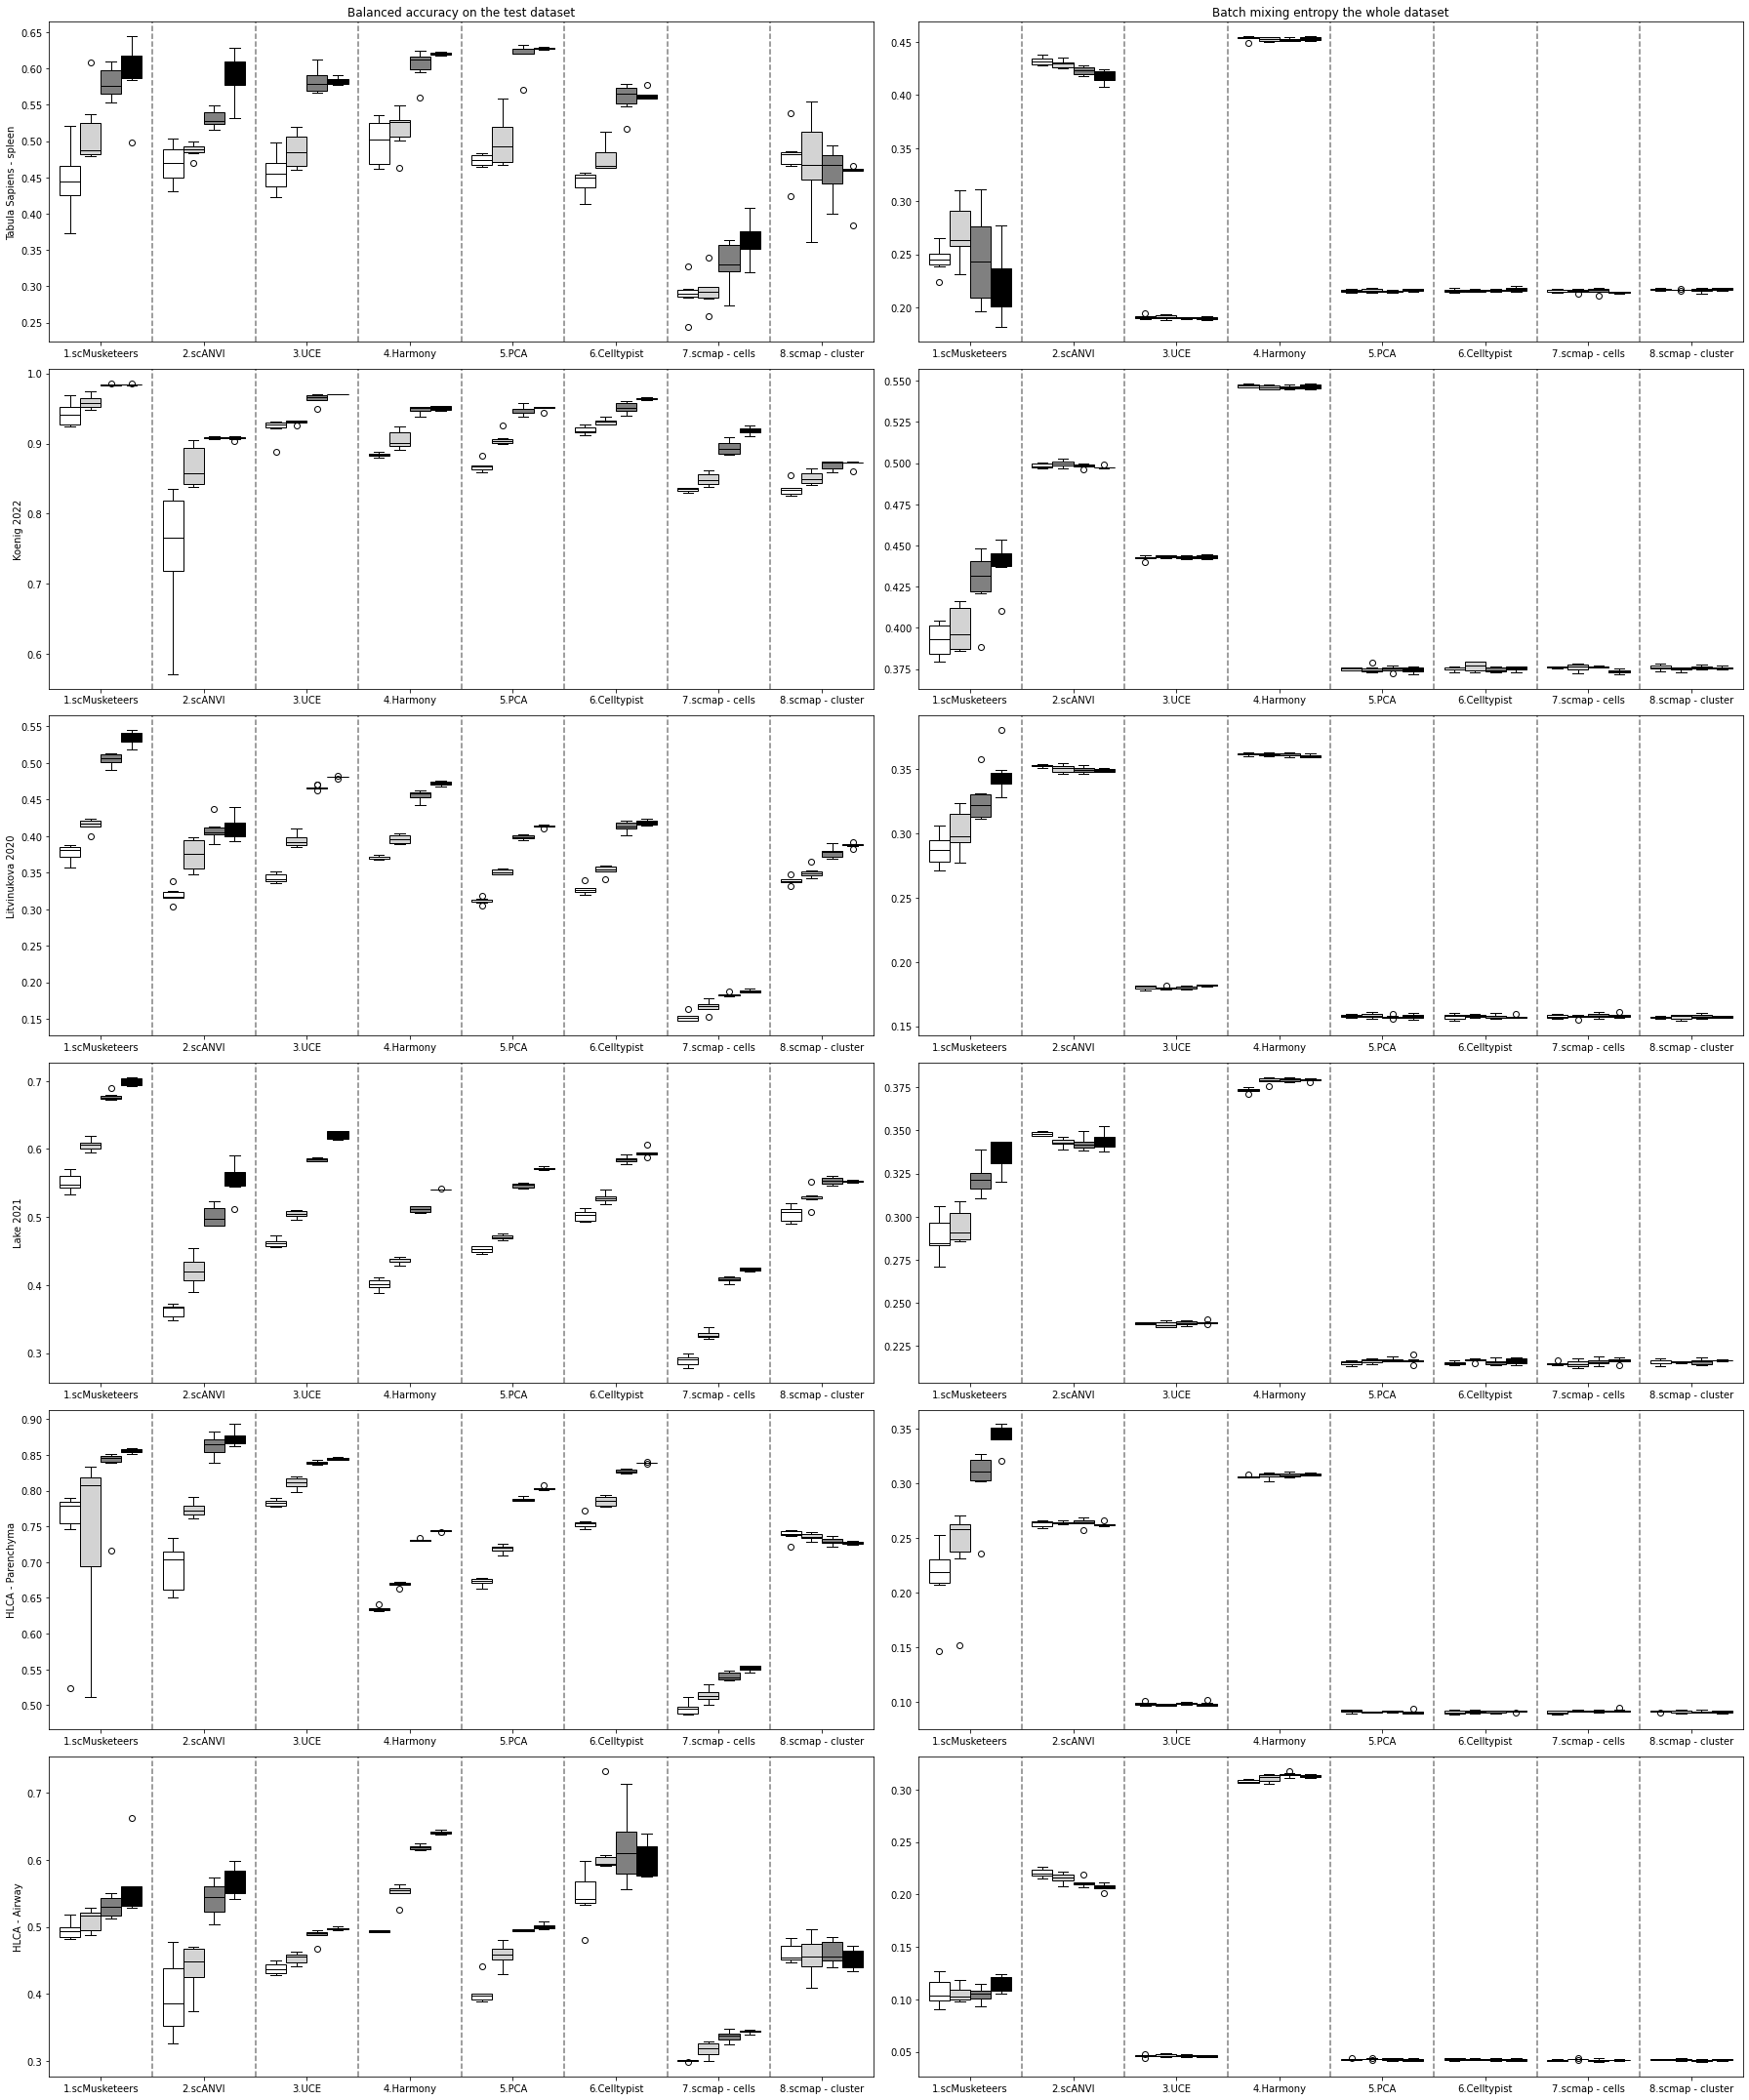

In [94]:
split = 'test'
met = 'balanced_acc'
mode = 'box' #'box'
exclude_ds = []
show_legend = False
models = list(colors.keys())
n_models = len(models)


pct_ticks = {0.05:'5%', 0.1:'10%', 0.5:'50%', 0.9:'90%'}
pct_values = list(pct_ticks.values())
pct_colors = {'5%':'white', '10%':'lightgrey', '50%':'grey', '90%':'black'}
ticks = {0.05:0,0.1:1,0.5:2,0.9:3}
n_ticks = len(ticks)

for diff in diff_dict:
    if diff != 'dataset':
        print(f'--------- {diff} ---------')
        n_lines = max(len([ i for i in diff_dict[diff] if i not in exclude_ds]),2)
        f, axes = plt.subplots(n_lines, 2, figsize = (25,5*n_lines))
        i=0
        for dataset_name in diff_dict[diff]:
            if dataset_name not in exclude_ds:
                
                task_2 = runs_table_df.query("task == 'task_2'").query(f"dataset_name == '{dataset_name}'").query(f"test_fold_nb == {test_fold_selection[dataset_name]}")
                print(dataset_name)
                print(task_2['debug_status'].value_counts())
                task_2['dataset_name'] =task_2['dataset_name'].replace(aestetic_data_name)
                task_2['model'] =task_2['model'].replace(aestetic_model_name)
                
                # task_2['model'] = pd.Categorical(task_2['model'], ['scPermut', 'scanvi', 'uce', 'pca_svm', 'harmony_svm', 'celltypist', 'scmap_cells', 'scmap_cluster']) 
                bplot1 = axes[i,0]
                bplot2 = axes[i,1]
                
                if mode == 'box':
                    # pct_split before model
                    # sns.boxplot(x = 'pct_split',y =f'{split}_{met}', hue = 'model', order = [0.05,0.1,0.5,0.9], hue_order = colors.keys(), data = task_2, ax = bplot1)

                    # model before pct_split
                    sns.boxplot(x = 'model',y =f'{split}_{met}',
                                hue = 'pct_split', order = colors.keys(), 
                                hue_order = [0.05,0.1,0.5,0.9], palette = sns.color_palette(pct_colors.values()),
                                data = task_2, ax = bplot1) 
                    
                for j in range(1, len(task_2['model'].unique())):
                    bplot1.axvline(x=j - 0.5, color='gray', linestyle='dashed', linewidth=1.5)

                # bplot1.set_xticks(list(ticks.values()), list(pct_ticks.values()))
                bplot1.tick_params(axis='x', rotation=0)
                if i == 0:
                    bplot1.set_title('Balanced accuracy on the test dataset')
                if i != n_lines:
                    bplot1.set_xlabel('')
                if i == n_lines:
                    bplot1.set_xlabel('Model')
                bplot1.set_ylabel(f'{aestetic_data_name[dataset_name]}') # - {diff} setup')
                bplot1.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)


                task_2['model'] = task_2['model'].replace({'Celltypist': 'PCA',
                           'scmap - cells': 'PCA',
                           'scmap - cluster': 'PCA'})
                colors_BE = {k:v for k, v in colors.items() if k not in ['Celltypist','scmap - cells','scmap - cluster']}
                
                sns.boxplot(x = 'model',y =f'full_batch_mixing_entropy', hue = 'pct_split', 
                            order = colors_BE.keys(), palette = sns.color_palette(pct_colors.values()),
                            hue_order = [0.05,0.1,0.5,0.9], data = task_2, ax = bplot2) 

                for j in range(1, len(task_2['model'].unique())):
                    bplot2.axvline(x=j - 0.5, color='gray', linestyle='dashed', linewidth=1.5)
                    
                bplot2.tick_params(axis='x', rotation=0)
                if i == 0:
                    bplot2.set_title('Batch mixing entropy the whole dataset')
                if i != n_lines:
                    bplot2.set_xlabel('')
                if i == n_lines:
                    bplot2.set_xlabel('Model')
                bplot2.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
                bplot2.set_ylabel('')
                
                if not show_legend: 
                    bplot1.get_legend().set_visible(False)
                    bplot2.get_legend().set_visible(False)
                
                # f.suptitle(f'{dataset_name} - {diff} setup')
                i+=1
                f.savefig(f'{fig_dir}task_2/prediction_boxplot_{diff}_{mode}_BW.png', transparent=False)
                
                plt.tight_layout()

--------- homo ---------
--------- assays ---------
--------- suspension ---------
--------- datasets ---------


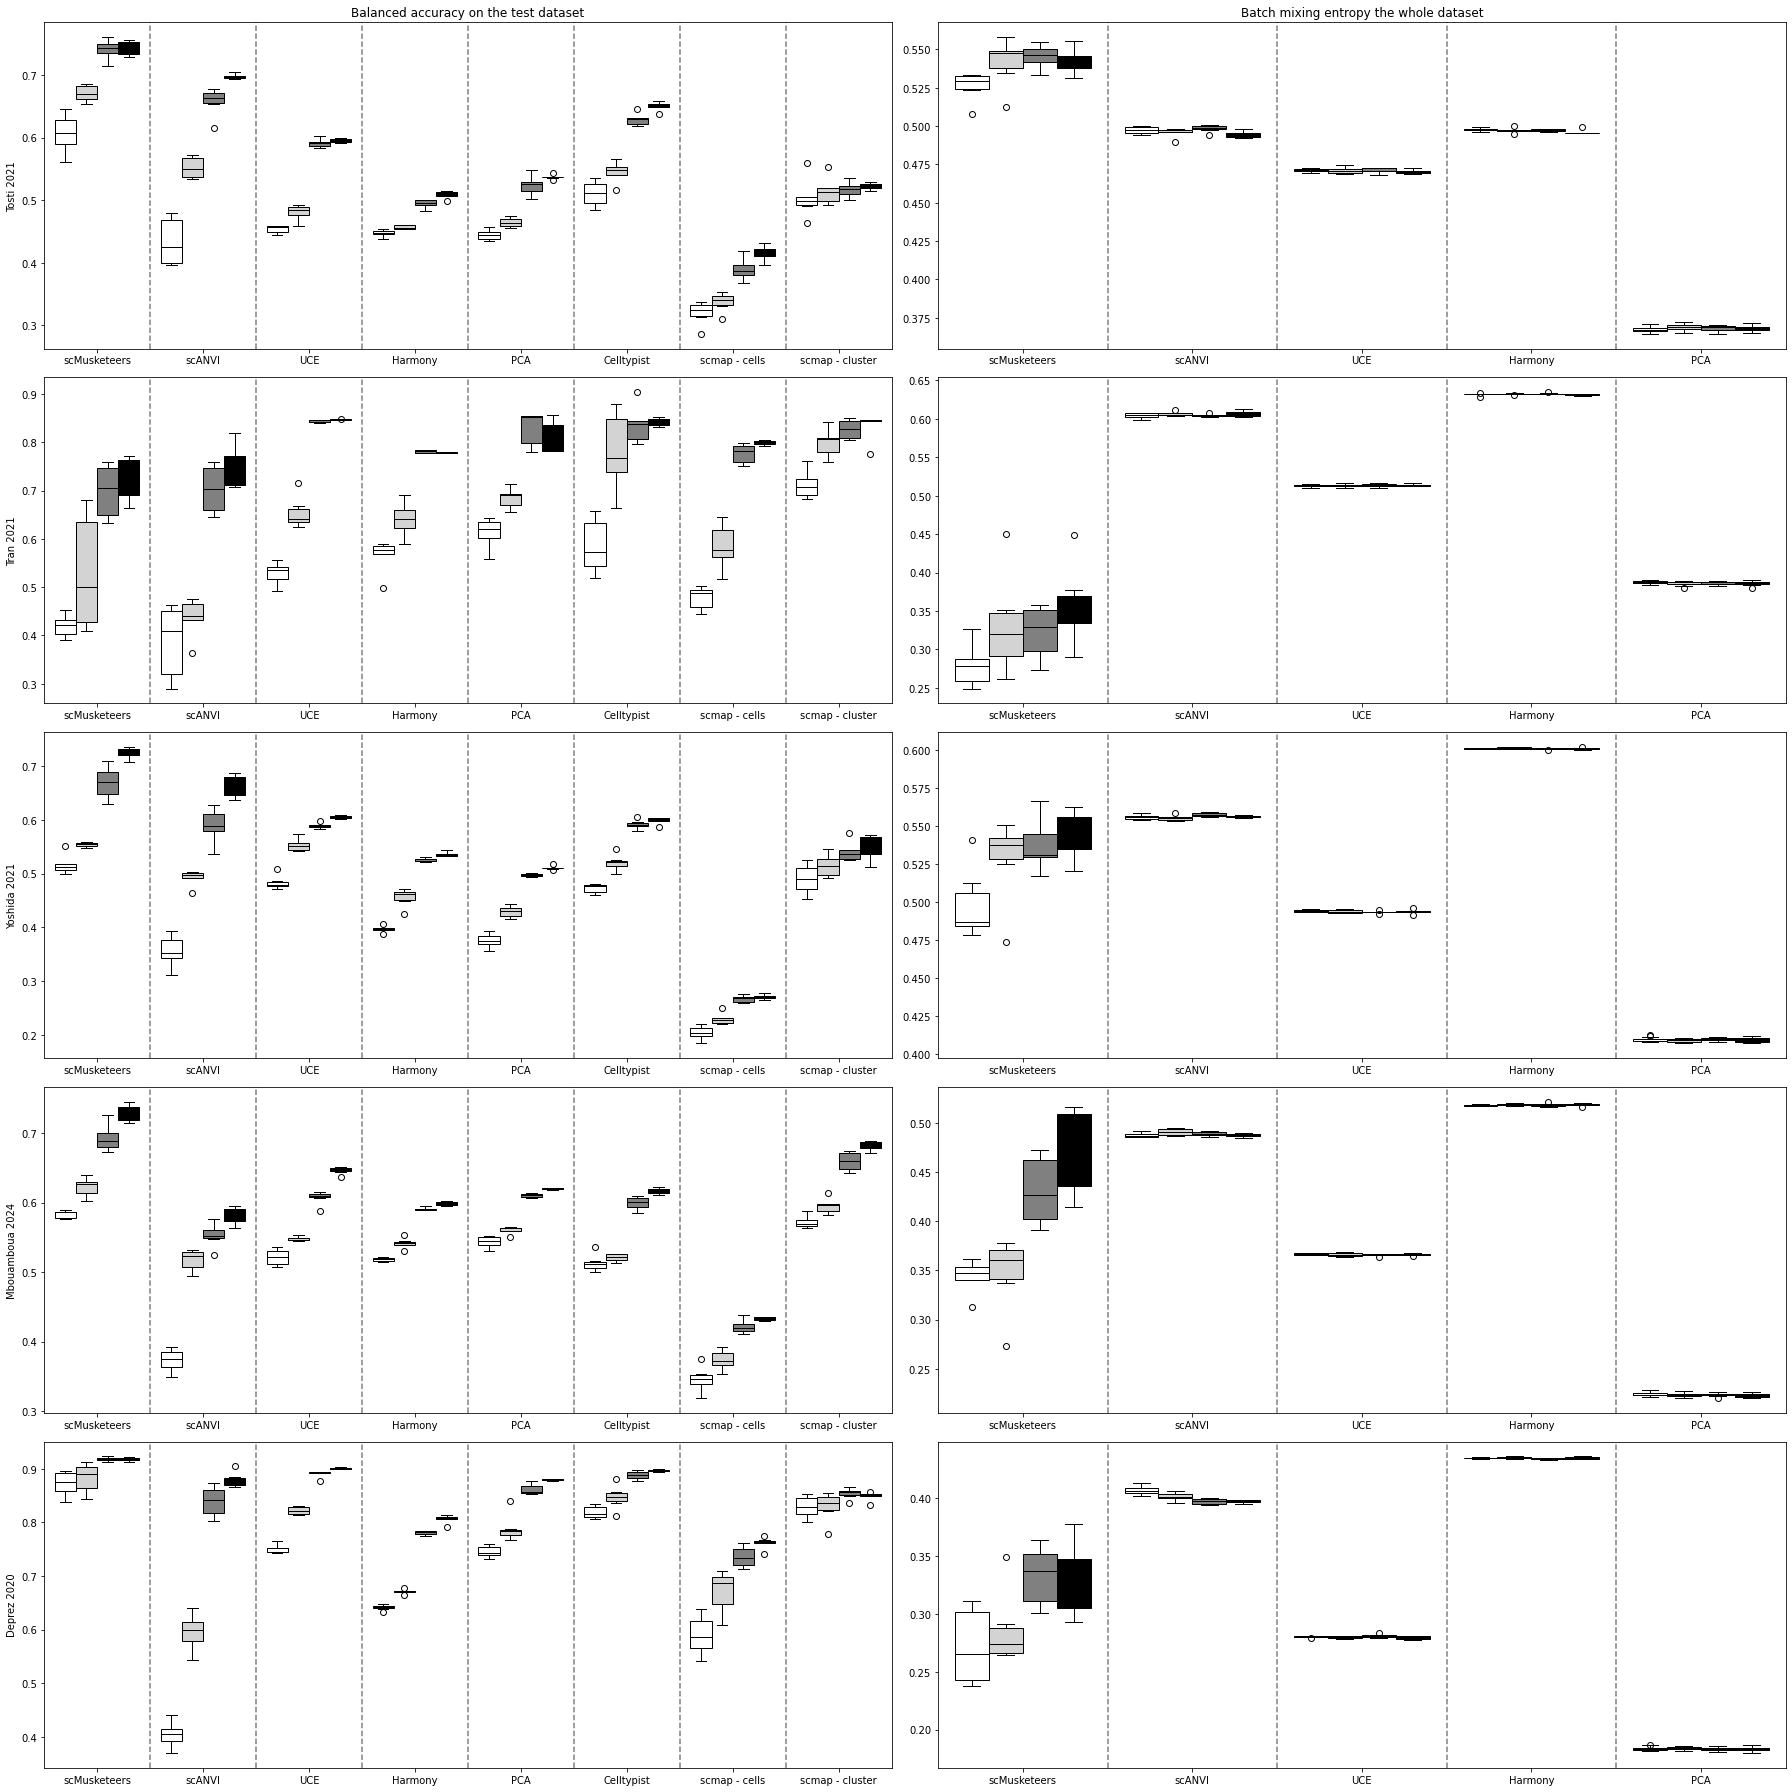

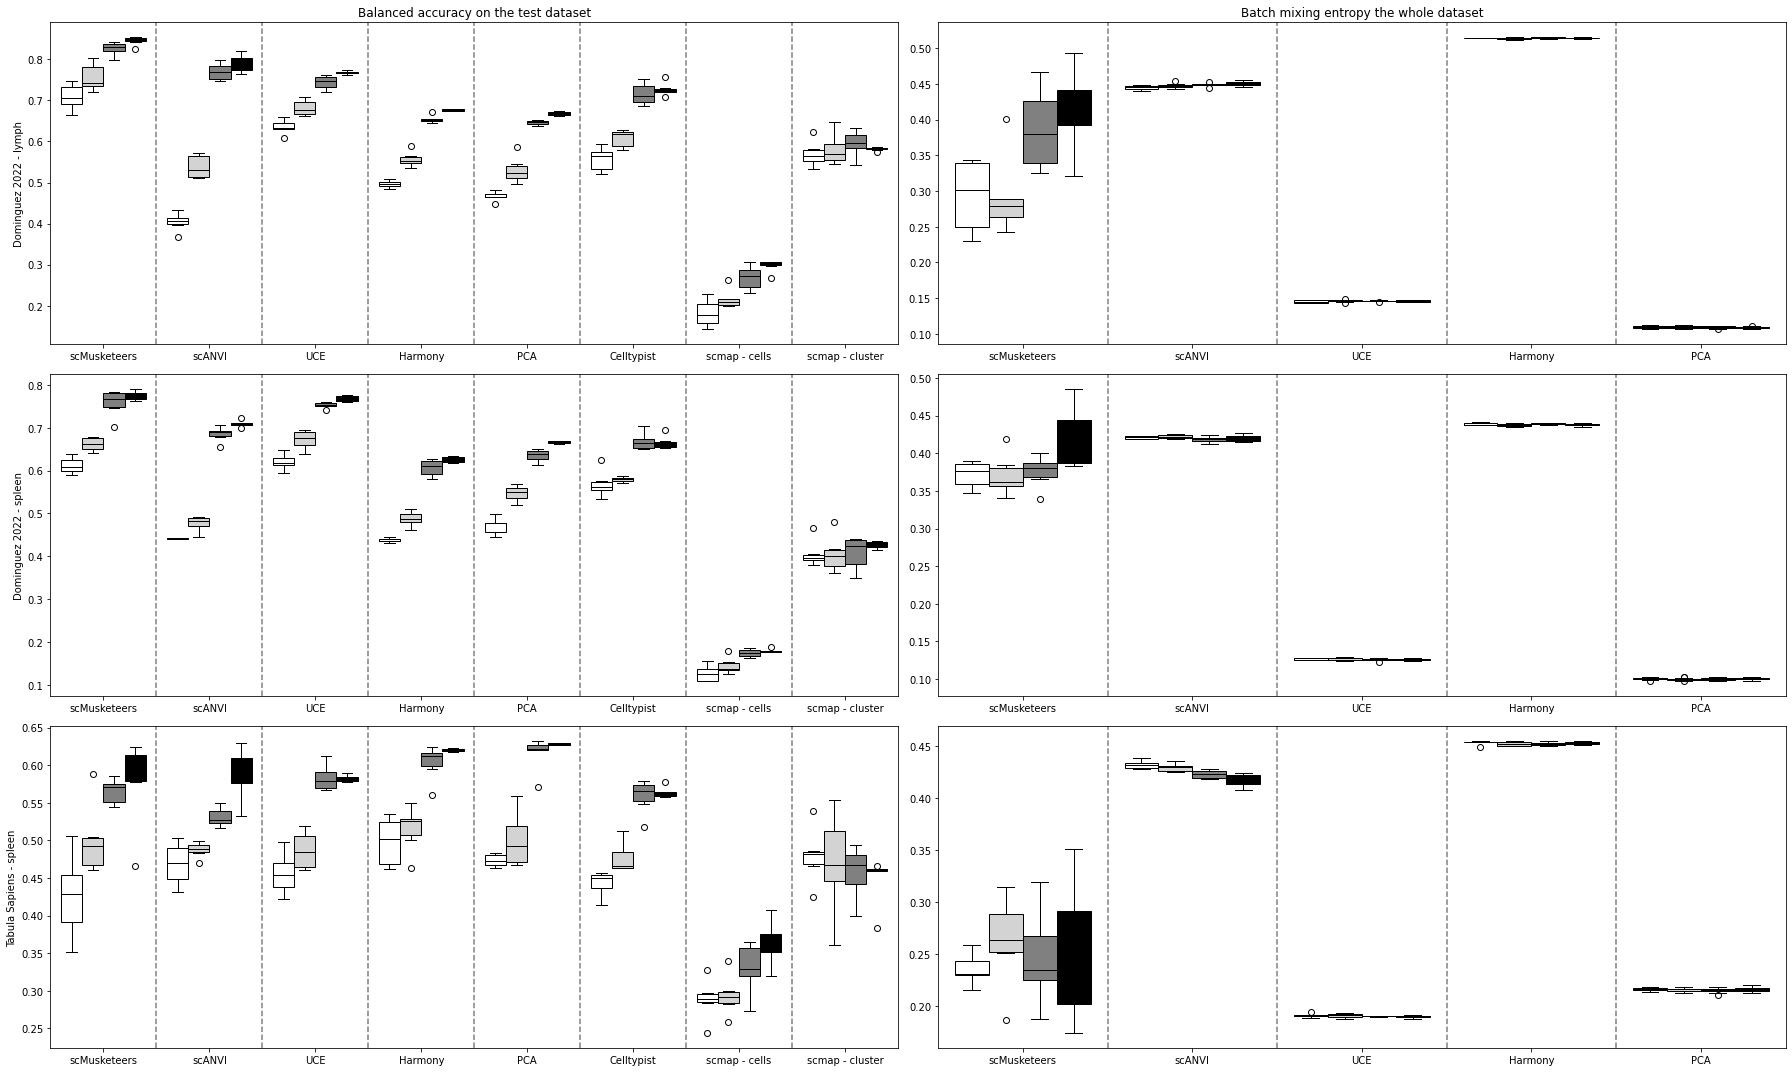

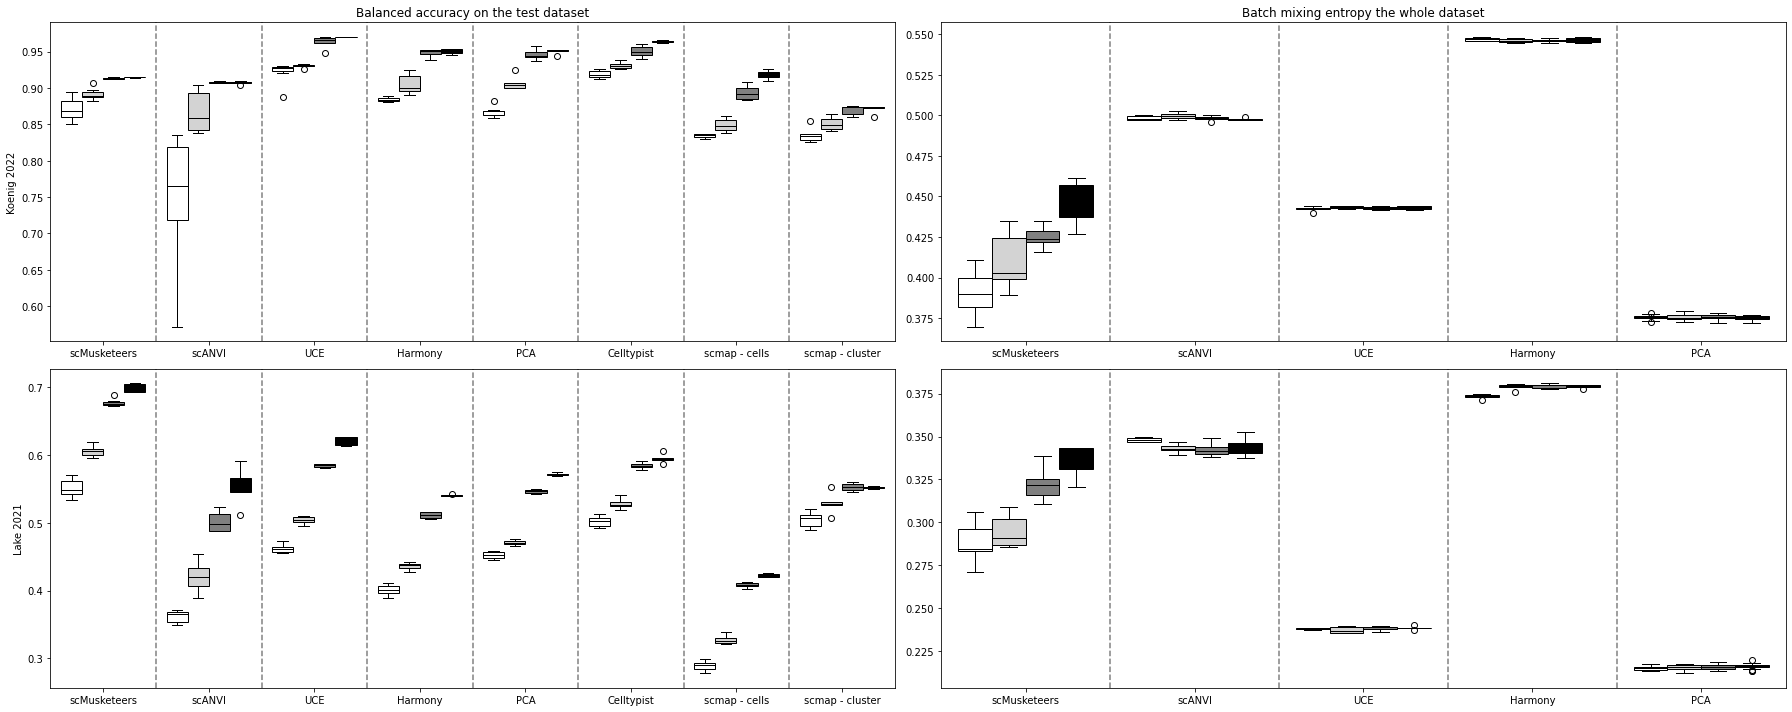

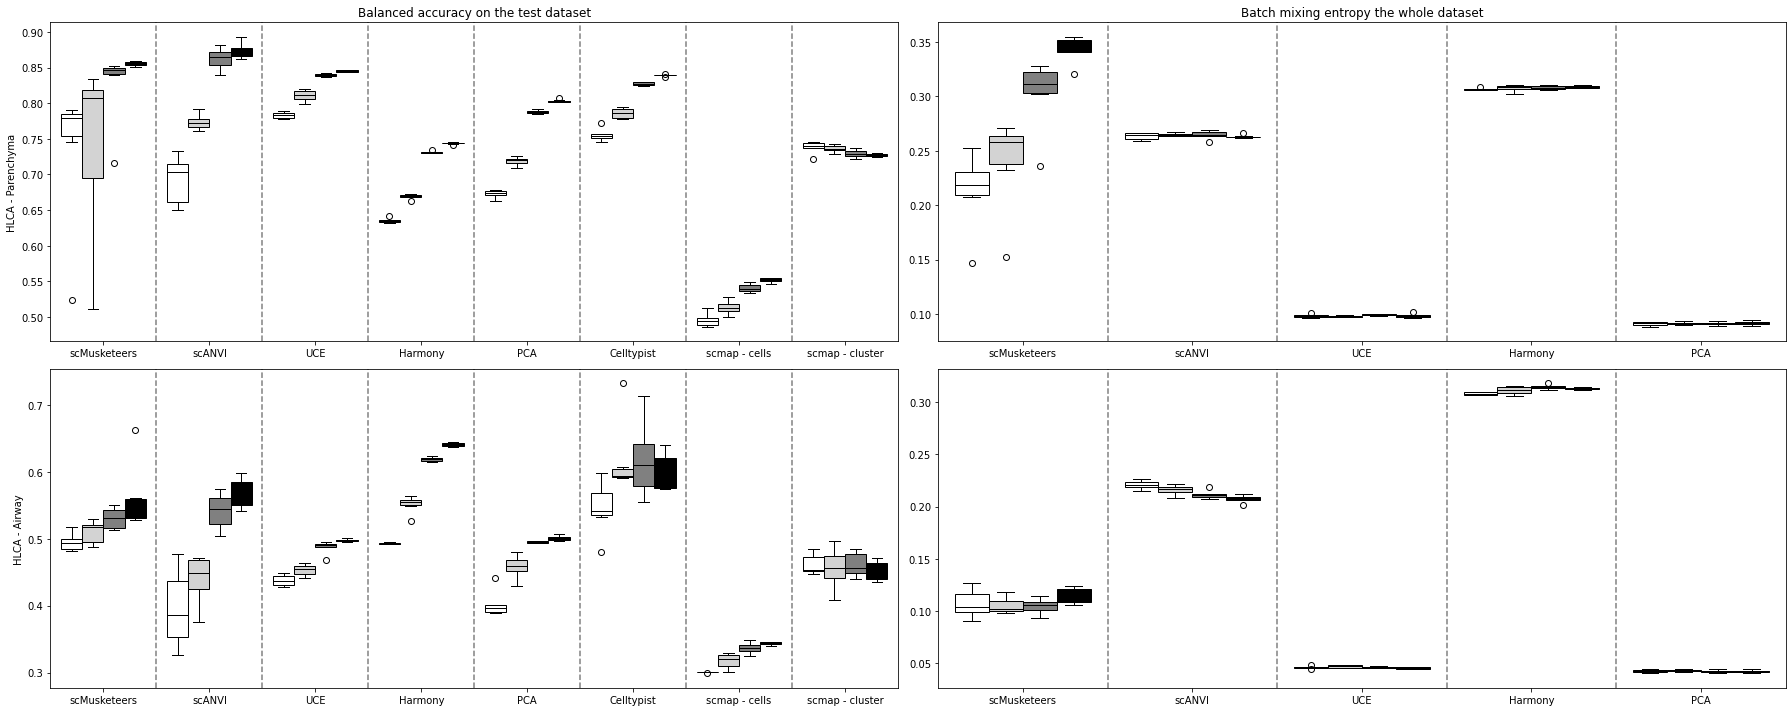

In [35]:
split = 'test'
met = 'balanced_acc'
mode = 'box' #'box'
exclude_ds = []
show_legend = False
models = list(colors.keys())
n_models = len(models)


pct_ticks = {0.05:'5%', 0.1:'10%', 0.5:'50%', 0.9:'90%'}
pct_values = list(pct_ticks.values())
pct_colors = {'5%':'white', '10%':'lightgrey', '50%':'grey', '90%':'black'}
ticks = {0.05:0,0.1:1,0.5:2,0.9:3}
n_ticks = len(ticks)

for diff in diff_dict:
    if diff != 'dataset':
        print(f'--------- {diff} ---------')
        n_lines = max(len([ i for i in diff_dict[diff] if i not in exclude_ds]),2)
        f, axes = plt.subplots(n_lines, 2, figsize = (25,5*n_lines))
        i=0
        for dataset_name in diff_dict[diff]:
            if dataset_name not in exclude_ds:
                
                task_2 = runs_table_df.query("task == 'task_2'").query(f"dataset_name == '{dataset_name}'").query(f"test_fold_nb == {test_fold_selection[dataset_name]}")
                
                task_2['dataset_name'] =task_2['dataset_name'].replace(aestetic_data_name)
                task_2['model'] =task_2['model'].replace(aestetic_model_name)
                
                # task_2['model'] = pd.Categorical(task_2['model'], ['scPermut', 'scanvi', 'uce', 'pca_svm', 'harmony_svm', 'celltypist', 'scmap_cells', 'scmap_cluster']) 
                bplot1 = axes[i,0]
                bplot2 = axes[i,1]
                
                if mode == 'box':
                    # pct_split before model
                    # sns.boxplot(x = 'pct_split',y =f'{split}_{met}', hue = 'model', order = [0.05,0.1,0.5,0.9], hue_order = colors.keys(), data = task_2, ax = bplot1)

                    # model before pct_split
                    sns.boxplot(x = 'model',y =f'{split}_{met}',
                                hue = 'pct_split', order = colors.keys(), 
                                hue_order = [0.05,0.1,0.5,0.9], palette = sns.color_palette(pct_colors.values()),
                                data = task_2, ax = bplot1) 
                    
                for j in range(1, len(task_2['model'].unique())):
                    bplot1.axvline(x=j - 0.5, color='gray', linestyle='dashed', linewidth=1.5)

                # bplot1.set_xticks(list(ticks.values()), list(pct_ticks.values()))
                bplot1.tick_params(axis='x', rotation=0)
                if i == 0:
                    bplot1.set_title('Balanced accuracy on the test dataset')
                if i != n_lines:
                    bplot1.set_xlabel('')
                if i == n_lines:
                    bplot1.set_xlabel('Model')
                bplot1.set_ylabel(f'{aestetic_data_name[dataset_name]}') # - {diff} setup')
                bplot1.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)


                task_2['model'] = task_2['model'].replace({'Celltypist': 'PCA',
                           'scmap - cells': 'PCA',
                           'scmap - cluster': 'PCA'})
                colors_BE = {k:v for k, v in colors.items() if k not in ['Celltypist','scmap - cells','scmap - cluster']}
                
                sns.boxplot(x = 'model',y =f'full_batch_mixing_entropy', hue = 'pct_split', 
                            order = colors_BE.keys(), palette = sns.color_palette(pct_colors.values()),
                            hue_order = [0.05,0.1,0.5,0.9], data = task_2, ax = bplot2) 

                for j in range(1, len(task_2['model'].unique())):
                    bplot2.axvline(x=j - 0.5, color='gray', linestyle='dashed', linewidth=1.5)
                    
                bplot2.tick_params(axis='x', rotation=0)
                if i == 0:
                    bplot2.set_title('Batch mixing entropy the whole dataset')
                if i != n_lines:
                    bplot2.set_xlabel('')
                if i == n_lines:
                    bplot2.set_xlabel('Model')
                bplot2.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
                bplot2.set_ylabel('')
                
                if not show_legend: 
                    bplot1.get_legend().set_visible(False)
                    bplot2.get_legend().set_visible(False)
                
                # f.suptitle(f'{dataset_name} - {diff} setup')
                i+=1
                f.savefig(f'{fig_dir}task_2/prediction_boxplot_{diff}_{mode}_BW.png', transparent=False)
                
                plt.tight_layout()

--------- all12 ---------
--------- tosti_2021 ---------
--------- yoshida_2021 ---------
--------- htap ---------
--------- ajrccm_by_batch ---------
--------- dominguez_2022_lymph ---------
--------- dominguez_2022_spleen ---------
--------- all22 ---------
--------- tabula_2022_spleen ---------
--------- koenig_2022 ---------
--------- lake_2021 ---------


/tmp/ipykernel_242227/1540069642.py:41: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(x='model',y ='value',hue = 'variable',order = abridged_colors.keys(),palette = sns.color_palette(pct_colors.values()),
/tmp/ipykernel_242227/1540069642.py:41: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(x='model',y ='value',hue = 'variable',order = abridged_colors.keys(),palette = sns.color_palette(pct_colors.values()),
/tmp/ipykernel_242227/1540069642.py:41: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(x='model',y ='value',hue = 'variable',order = abridged_colors.keys(),palette = sns.color_palette(pct_colors.values()),
/tmp/ipykernel_242227/1540069642.py:41: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(x='model',y ='value',hue = 'variable',order = abrid

--------- hlca_par_dataset_harmonized ---------
--------- hlca_trac_dataset_harmonized ---------


/tmp/ipykernel_242227/1540069642.py:41: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(x='model',y ='value',hue = 'variable',order = abridged_colors.keys(),palette = sns.color_palette(pct_colors.values()),
/tmp/ipykernel_242227/1540069642.py:41: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(x='model',y ='value',hue = 'variable',order = abridged_colors.keys(),palette = sns.color_palette(pct_colors.values()),
/tmp/ipykernel_242227/1540069642.py:41: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(x='model',y ='value',hue = 'variable',order = abridged_colors.keys(),palette = sns.color_palette(pct_colors.values()),
/tmp/ipykernel_242227/1540069642.py:41: UserWarning: The palette list has more values (4) than needed (3), which may not be intended.
  sns.boxplot(x='model',y ='value',hue = 'variable',order = abrid

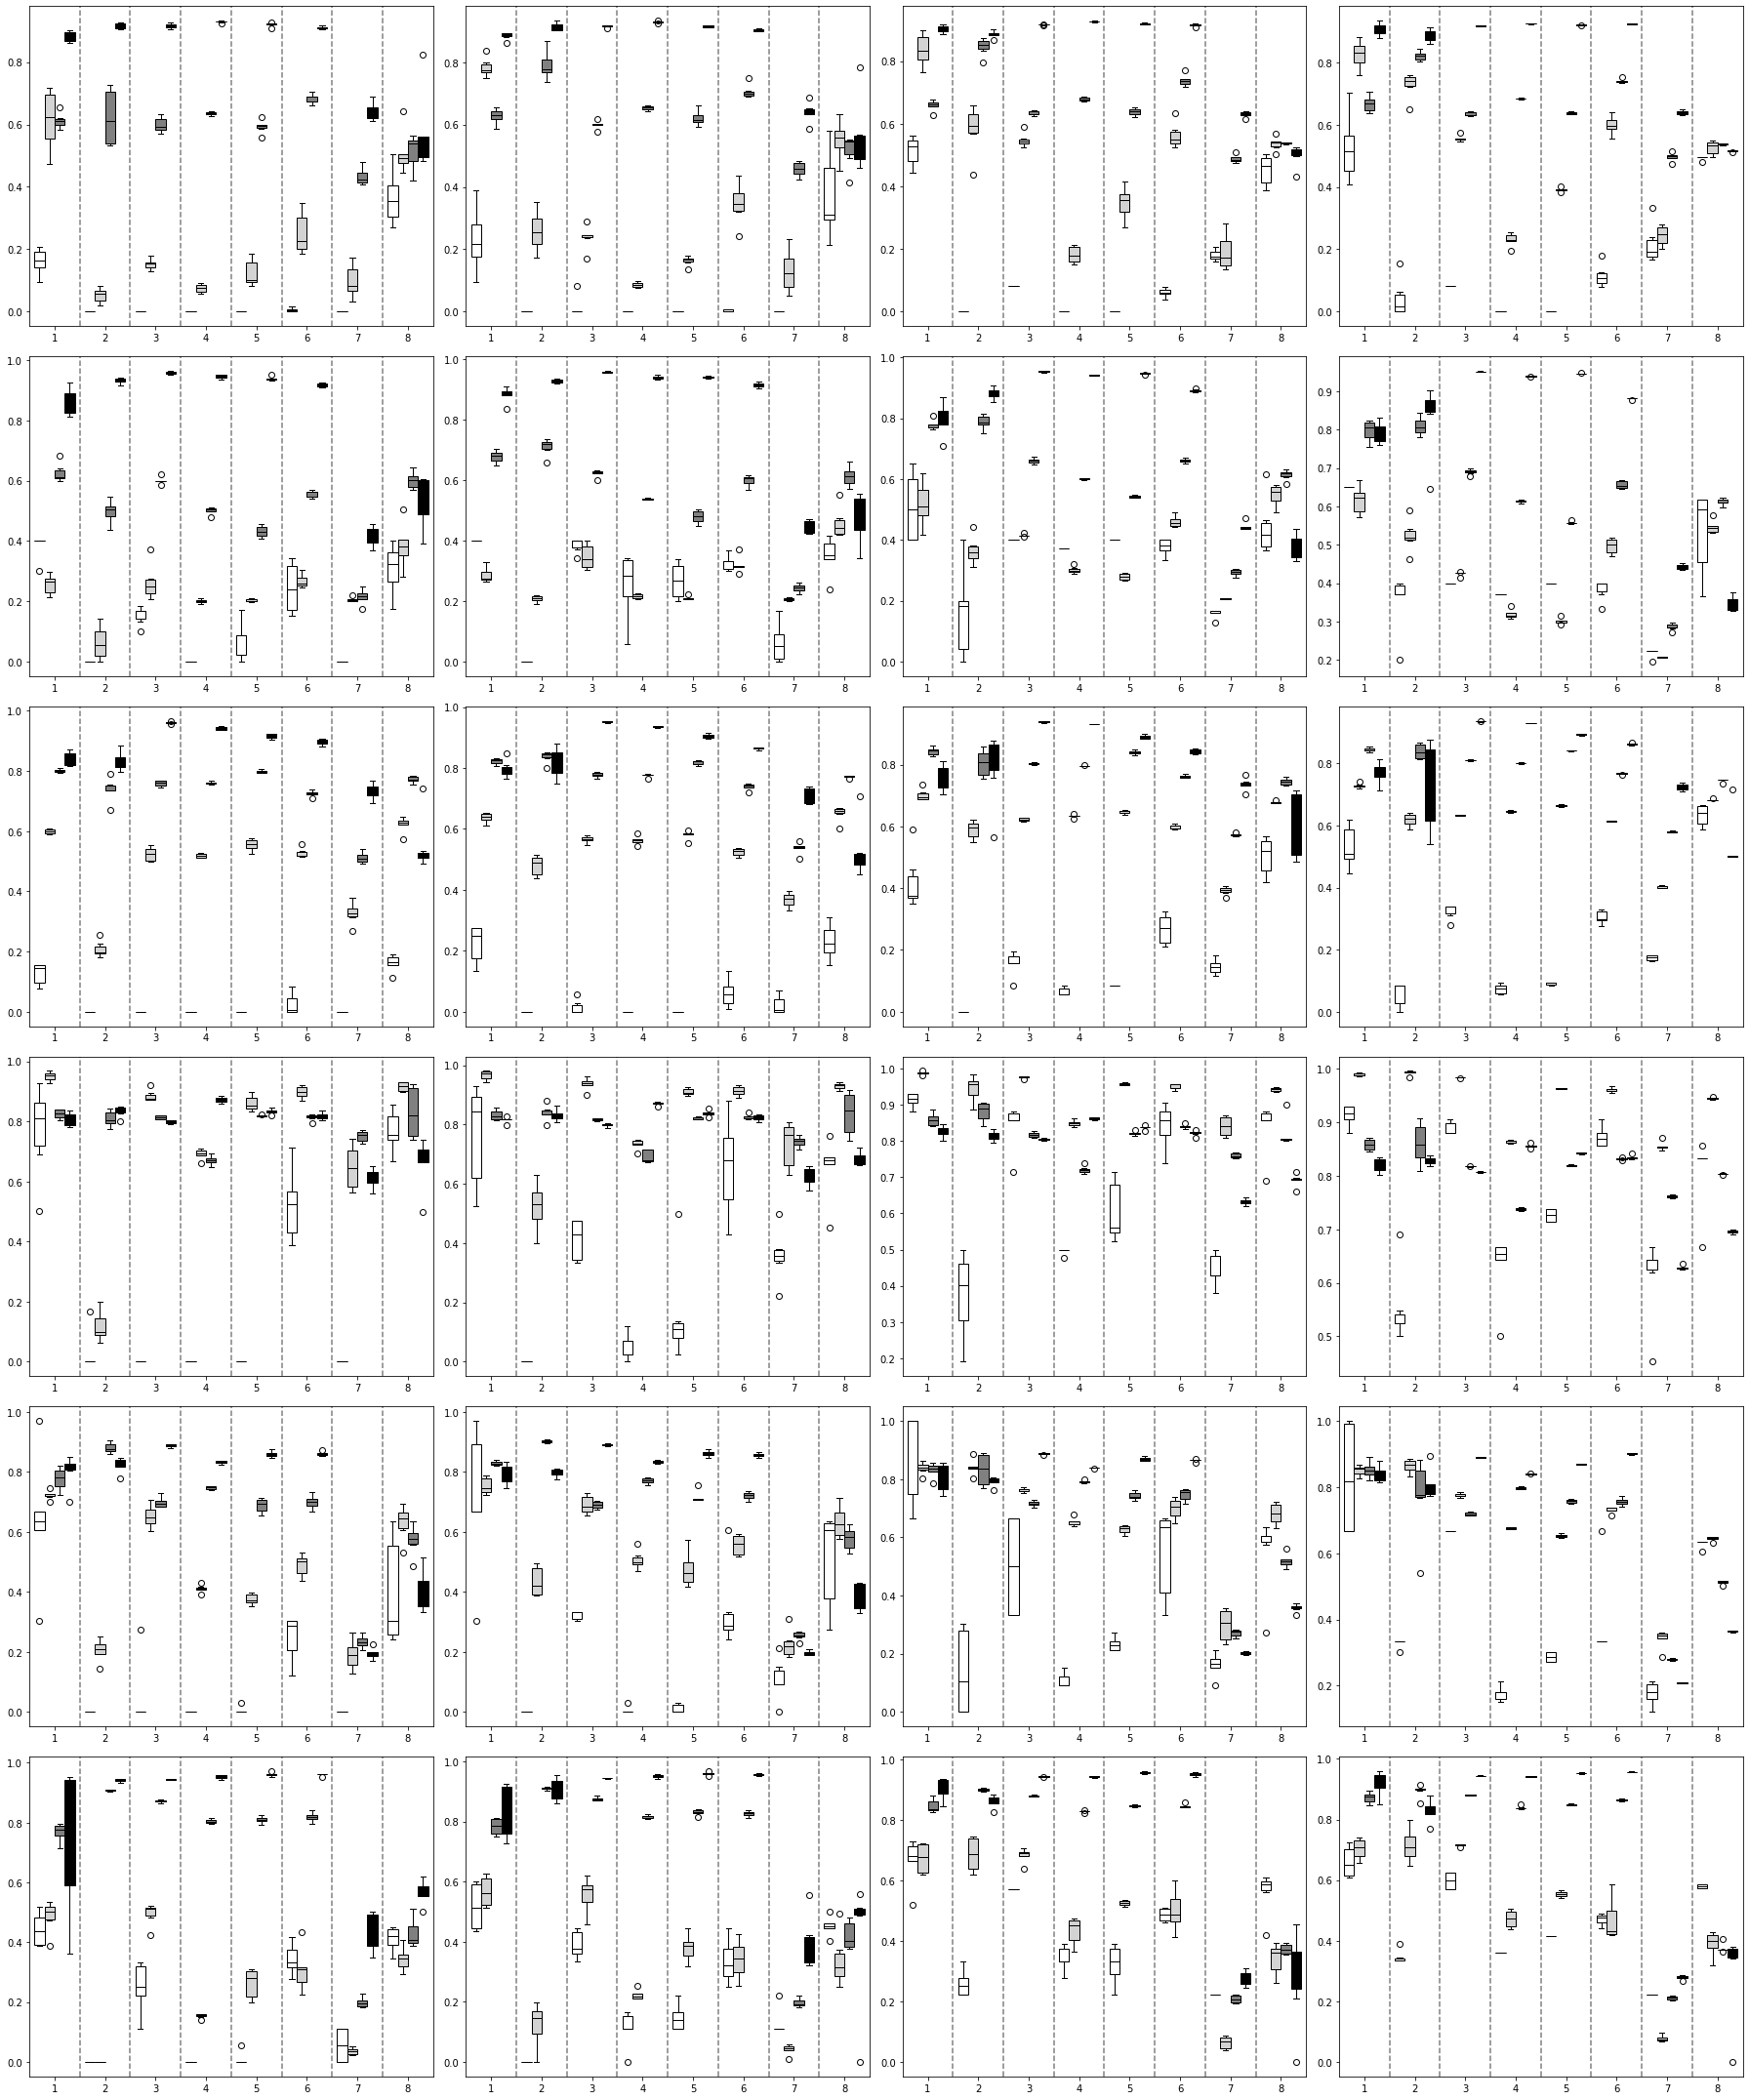

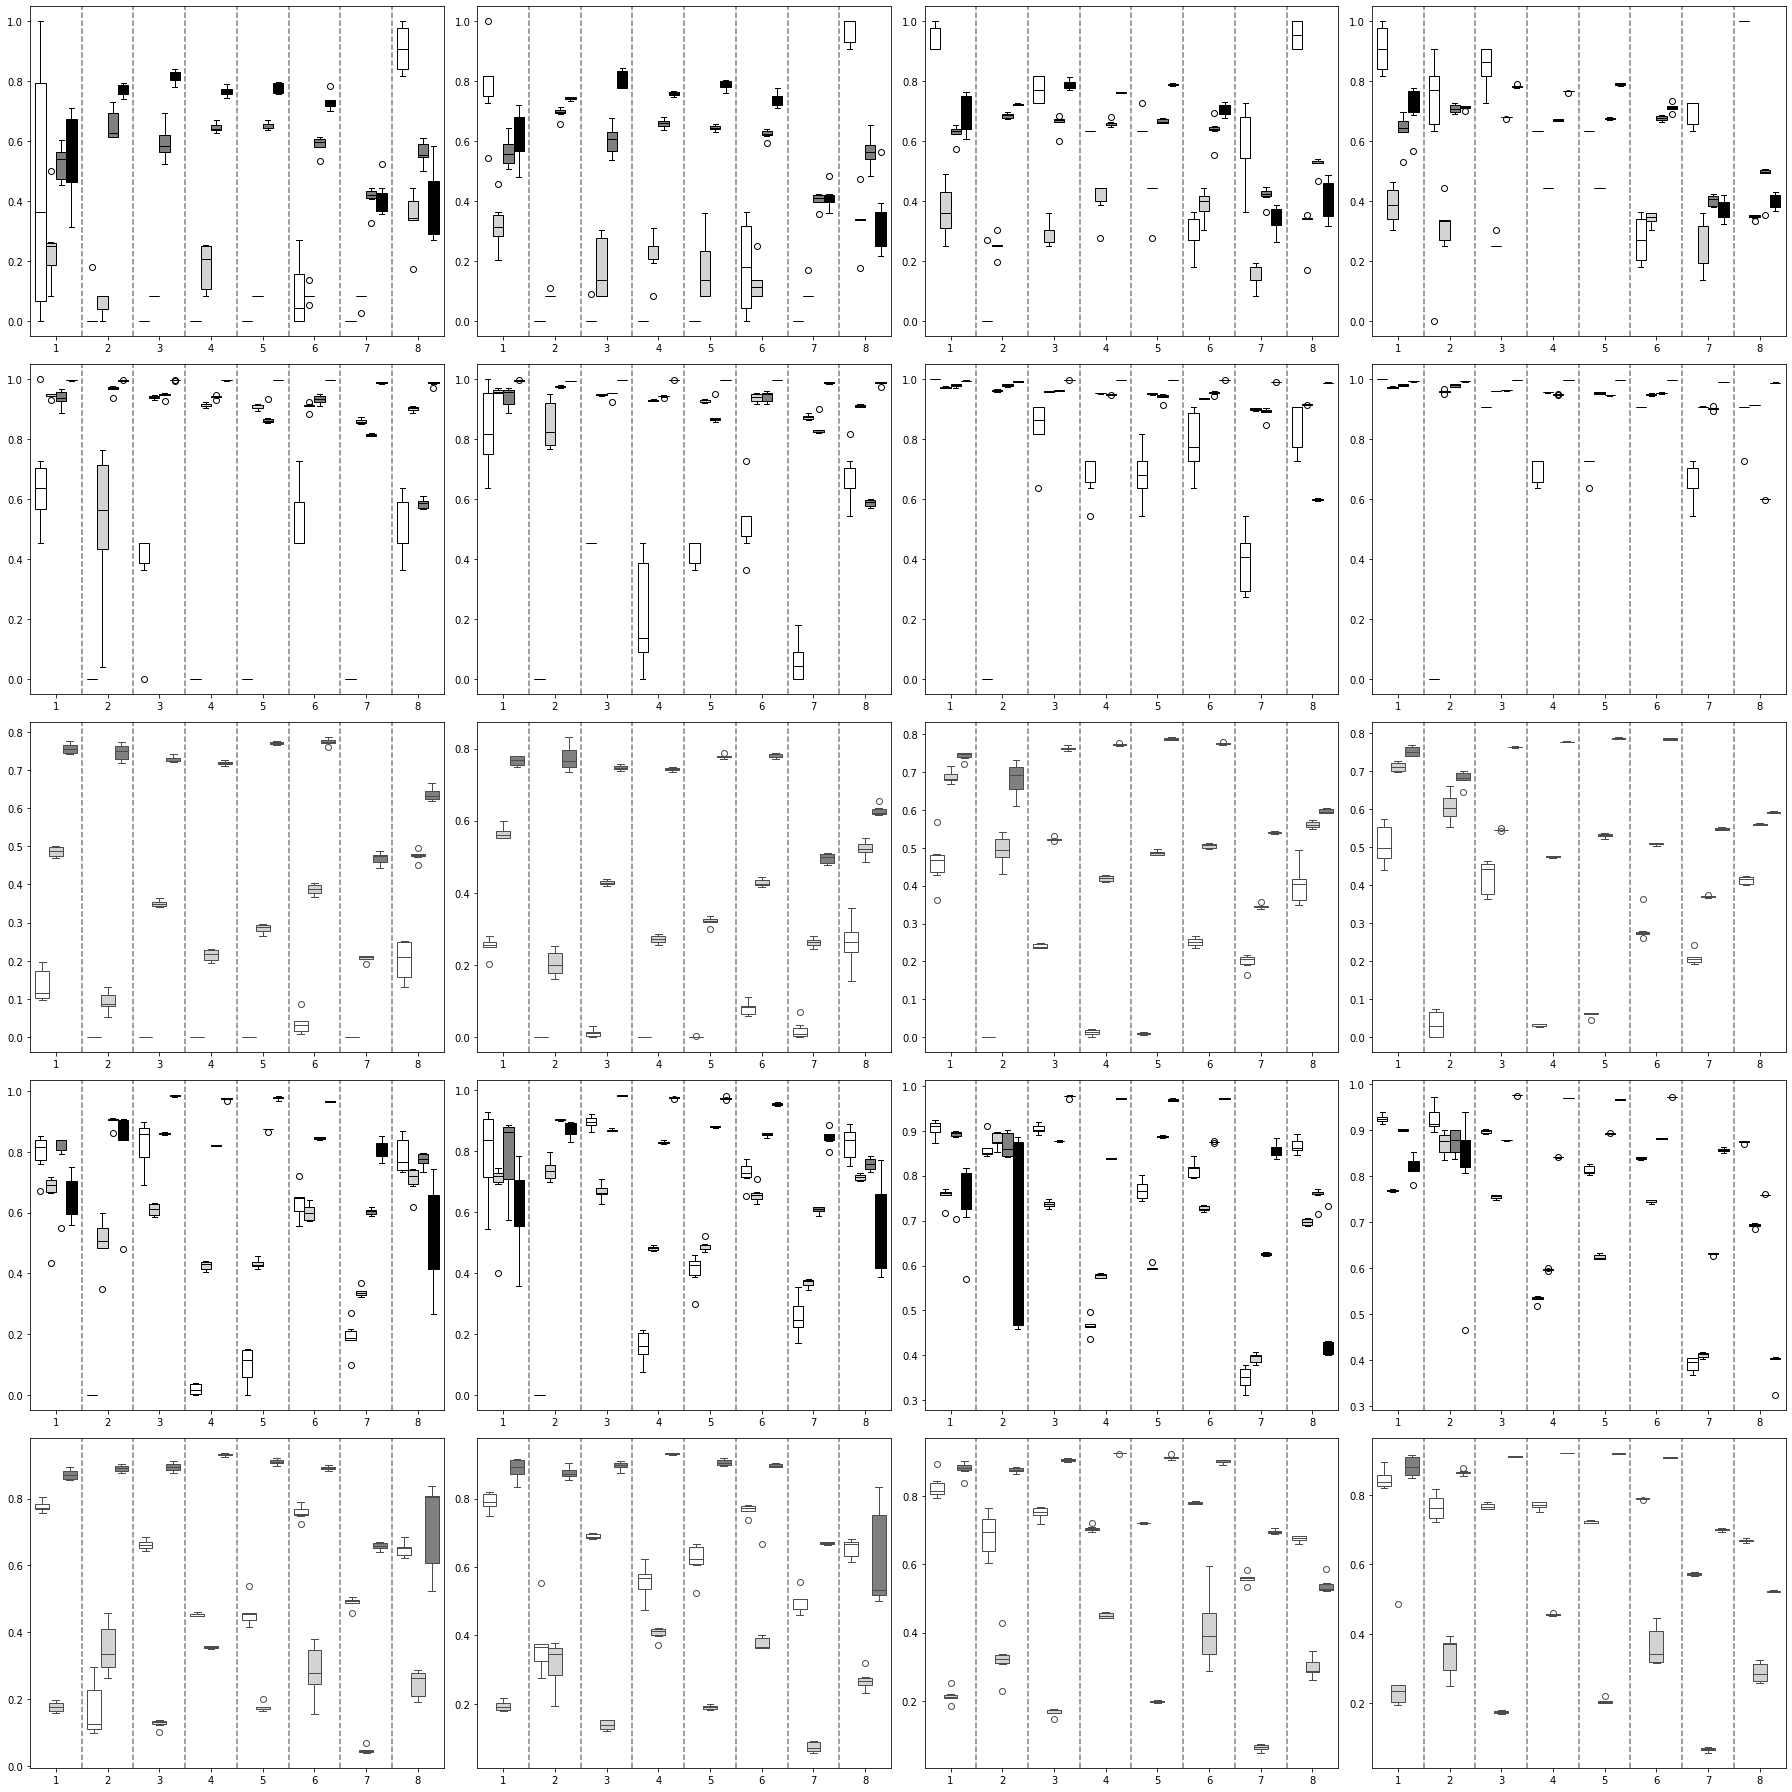

In [96]:
split = 'test'
met = 'balanced_acc'
show_legend = False
exclude_ds = ['litvinukova_2020']

ds = [i for v in diff_dict.values() for i in v]

for diff in diff_dict:
    if diff != 'dataset':
        print(f'--------- {diff} ---------')
        n_lines = max(len([ i for i in diff_dict[diff] if i not in exclude_ds]),2)
        f, axes = plt.subplots(n_lines, 4, figsize = (25,5*n_lines))
        i=0
            
        for dataset_name in diff_dict[diff]:
            if dataset_name not in exclude_ds:
                print(f'--------- {dataset_name} ---------')
                
                
                for j, pct_split in enumerate([0.05,0.1,0.5,0.9]):
                    bplot1 = axes[i,j]
                    
                    task_2 = runs_table_df.query("task == 'task_2'").query(f"dataset_name == '{dataset_name}'").query(f"test_fold_nb == {test_fold_selection[dataset_name]}").query(f'pct_split == {pct_split}')
            
                    task_2['dataset_name'] =task_2['dataset_name'].replace(aestetic_data_name)
                    task_2['model'] =task_2['model'].replace(abridged_model_name)
                    
                    sub =task_2[['model', 'test_fold_nb',f'{split}_balanced_acc', f'{split}_xxsmall_balanced_acc',f'{split}_small_balanced_acc', f'{split}_medium_balanced_acc', f'{split}_large_balanced_acc']]
                    sub = pd.melt(sub, id_vars = 'model', value_vars = [f'{split}_xxsmall_balanced_acc',f'{split}_small_balanced_acc', f'{split}_medium_balanced_acc', f'{split}_large_balanced_acc'])
                    sub = sub.replace({f'{split}_xxsmall_balanced_acc' : '<0.1%',f'{split}_small_balanced_acc':'<1%', f'{split}_medium_balanced_acc':'<10%',f'{split}_large_balanced_acc':'>10%'})
            
                    
                    if dataset_name in ['tran_2021',aestetic_data_name['tran_2021'], 
                                        'hlca_trac_dataset_harmonized', aestetic_data_name['hlca_trac_dataset_harmonized']]:
                        ord =  ['<1%','<10%','>10%']
                    elif dataset_name in ['lake_2021', aestetic_data_name['lake_2021']]:
                        ord =  ['<0.1%','<1%','<10%']
                    else :
                        ord = ['<0.1%','<1%','<10%','>10%']
            
                    sns.boxplot(x='model',y ='value',hue = 'variable',order = abridged_colors.keys(),palette = sns.color_palette(pct_colors.values()),
                                hue_order =ord , data = sub,ax = bplot1)


                    for j in range(1, 8):
                        bplot1.axvline(x=j - 0.5, color='gray', linestyle='dashed', linewidth=1.5)
                        
                    bplot1.tick_params(axis='x', rotation=0)
                    bplot1.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
                    
                    
                    if i != n_lines:
                        bplot1.set_xlabel('')
                    if i == n_lines:
                        bplot1.set_xlabel('Celltype size')
    
                    if j == 0:
                        bplot1.set_ylabel(aestetic_data_name[dataset_name])
                    else : 
                        bplot1.set_ylabel('')
                    # if i == 0:
                    #     bplot1.set_title(f'Train on {pct_ticks[pct_split]} of data')
    
                    if not show_legend: 
                        bplot1.get_legend().set_visible(False)
                        
                i+=1
            plt.tight_layout()
            # f.suptitle(f'Balanced accuracy by celltype sizes') # in {aestetic_data_name[dataset_name]}')
            f.savefig(f'{fig_dir}task_2/by_size/prediction_boxplot_by_size_{diff}_BW.png', transparent=False)


## hue = model (NOT IN PAPER)

In [ ]:
split = 'test'
met = 'balanced_acc'
mode = 'box' #'box'
exclude_ds = []
show_legend = False
models = list(colors.keys())
n_models = len(models)
pct_values = list(pct_ticks.values())

pct_ticks = {0.05:'5%', 0.1:'10%', 0.5:'50%', 0.9:'90%'}
ticks = {0.05:0,0.1:1,0.5:2,0.9:3}
n_ticks = len(ticks)

for diff in diff_dict:
    if diff != 'dataset':
        print(f'--------- {diff} ---------')
        n_lines = max(len([ i for i in diff_dict[diff] if i not in exclude_ds]),2)
        f, axes = plt.subplots(n_lines, 2, figsize = (25,5*n_lines))
        i=0
        for dataset_name in diff_dict[diff]:
            if dataset_name not in exclude_ds:
                
                task_2 = runs_table_df.query("task == 'task_2'").query(f"dataset_name == '{dataset_name}'").query(f"test_fold_nb == {test_fold_selection[dataset_name]}")
                
                task_2['dataset_name'] =task_2['dataset_name'].replace(aestetic_data_name)
                task_2['model'] =task_2['model'].replace(aestetic_model_name)
                
                # task_2['model'] = pd.Categorical(task_2['model'], ['scPermut', 'scanvi', 'uce', 'pca_svm', 'harmony_svm', 'celltypist', 'scmap_cells', 'scmap_cluster']) 
                bplot1 = axes[i,0]
                bplot2 = axes[i,1]

                if mode == 'box':
                    # pct_split before model
                    sns.boxplot(x = 'pct_split',y =f'{split}_{met}', hue = 'model', 
                                order = [0.05,0.1,0.5,0.9], hue_order = colors.keys(), data = task_2, ax = bplot1)                    
    
                elif mode == 'line': 
                    ticks = {0.05:1,0.1:2,0.5:3,0.9:4}
                    t2 = task_2.copy()
                    t2['pct_split'] = task_2['pct_split'].replace(ticks)
                    
                    ax = sns.lineplot(x = 'pct_split',y =f'{split}_{met}', hue = 'model',err_style="bars", errorbar=("se", 2),ax = bplot1,
                                 hue_order = colors.keys(), data = t2, palette = sns.color_palette(colors.values()))
                    ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
                    # plt.xticks(list(ticks.values()), list(pct_ticks.values()))
                bplot1.set_xticks(list(ticks.values()), list(pct_ticks.values()))
                bplot1.tick_params(axis='x', rotation=0)
                if i == 0:
                    bplot1.set_title('Balanced accuracy on the test dataset')
                if i != n_lines:
                    bplot1.set_xlabel('')
                if i == n_lines:
                    bplot1.set_xlabel('Model')
                bplot1.set_ylabel(f'{aestetic_data_name[dataset_name]}') # - {diff} setup')
                bplot1.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)


                task_2['model'] = task_2['model'].replace({'Celltypist': 'PCA',
                           'scmap - cells': 'PCA',
                           'scmap - cluster': 'PCA'})
                colors_BE = {k:v for k, v in colors.items() if k not in ['Celltypist','scmap - cells','scmap - cluster']}

                sns.boxplot(x = 'pct_split',y =f'full_batch_mixing_entropy', hue = 'model', order = [0.05,0.1,0.5,0.9], hue_order = colors_BE.keys(), data = task_2, ax = bplot2, palette = sns.color_palette(colors_BE.values()))
                bplot2.tick_params(axis='x', rotation=0)
                if i == 0:
                    bplot2.set_title('Batch mixing entropy the whole dataset')
                if i != n_lines:
                    bplot2.set_xlabel('')
                if i == n_lines:
                    bplot2.set_xlabel('Model')
                bplot2.set_xticks(list(ticks.values()), list(pct_ticks.values()))
                bplot2.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
                bplot2.set_ylabel('')
                
                if not show_legend: 
                    bplot1.get_legend().set_visible(False)
                    bplot2.get_legend().set_visible(False)
                    # bplot3.get_legend().set_visible(False)
                
                # f.suptitle(f'{dataset_name} - {diff} setup')
                i+=1
                # f.savefig(f'{fig_dir}task_2/prediction_boxplot_{diff}_{mode}.png', transparent=False)
                
                plt.tight_layout()

--------- all12 ---------
--------- tosti_2021 ---------
--------- yoshida_2021 ---------
--------- htap ---------
--------- ajrccm_by_batch ---------
--------- dominguez_2022_lymph ---------
--------- dominguez_2022_spleen ---------
--------- all22 ---------
--------- tabula_2022_spleen ---------
--------- koenig_2022 ---------
--------- litvinukova_2020 ---------
--------- lake_2021 ---------
--------- hlca_par_dataset_harmonized ---------
--------- hlca_trac_dataset_harmonized ---------


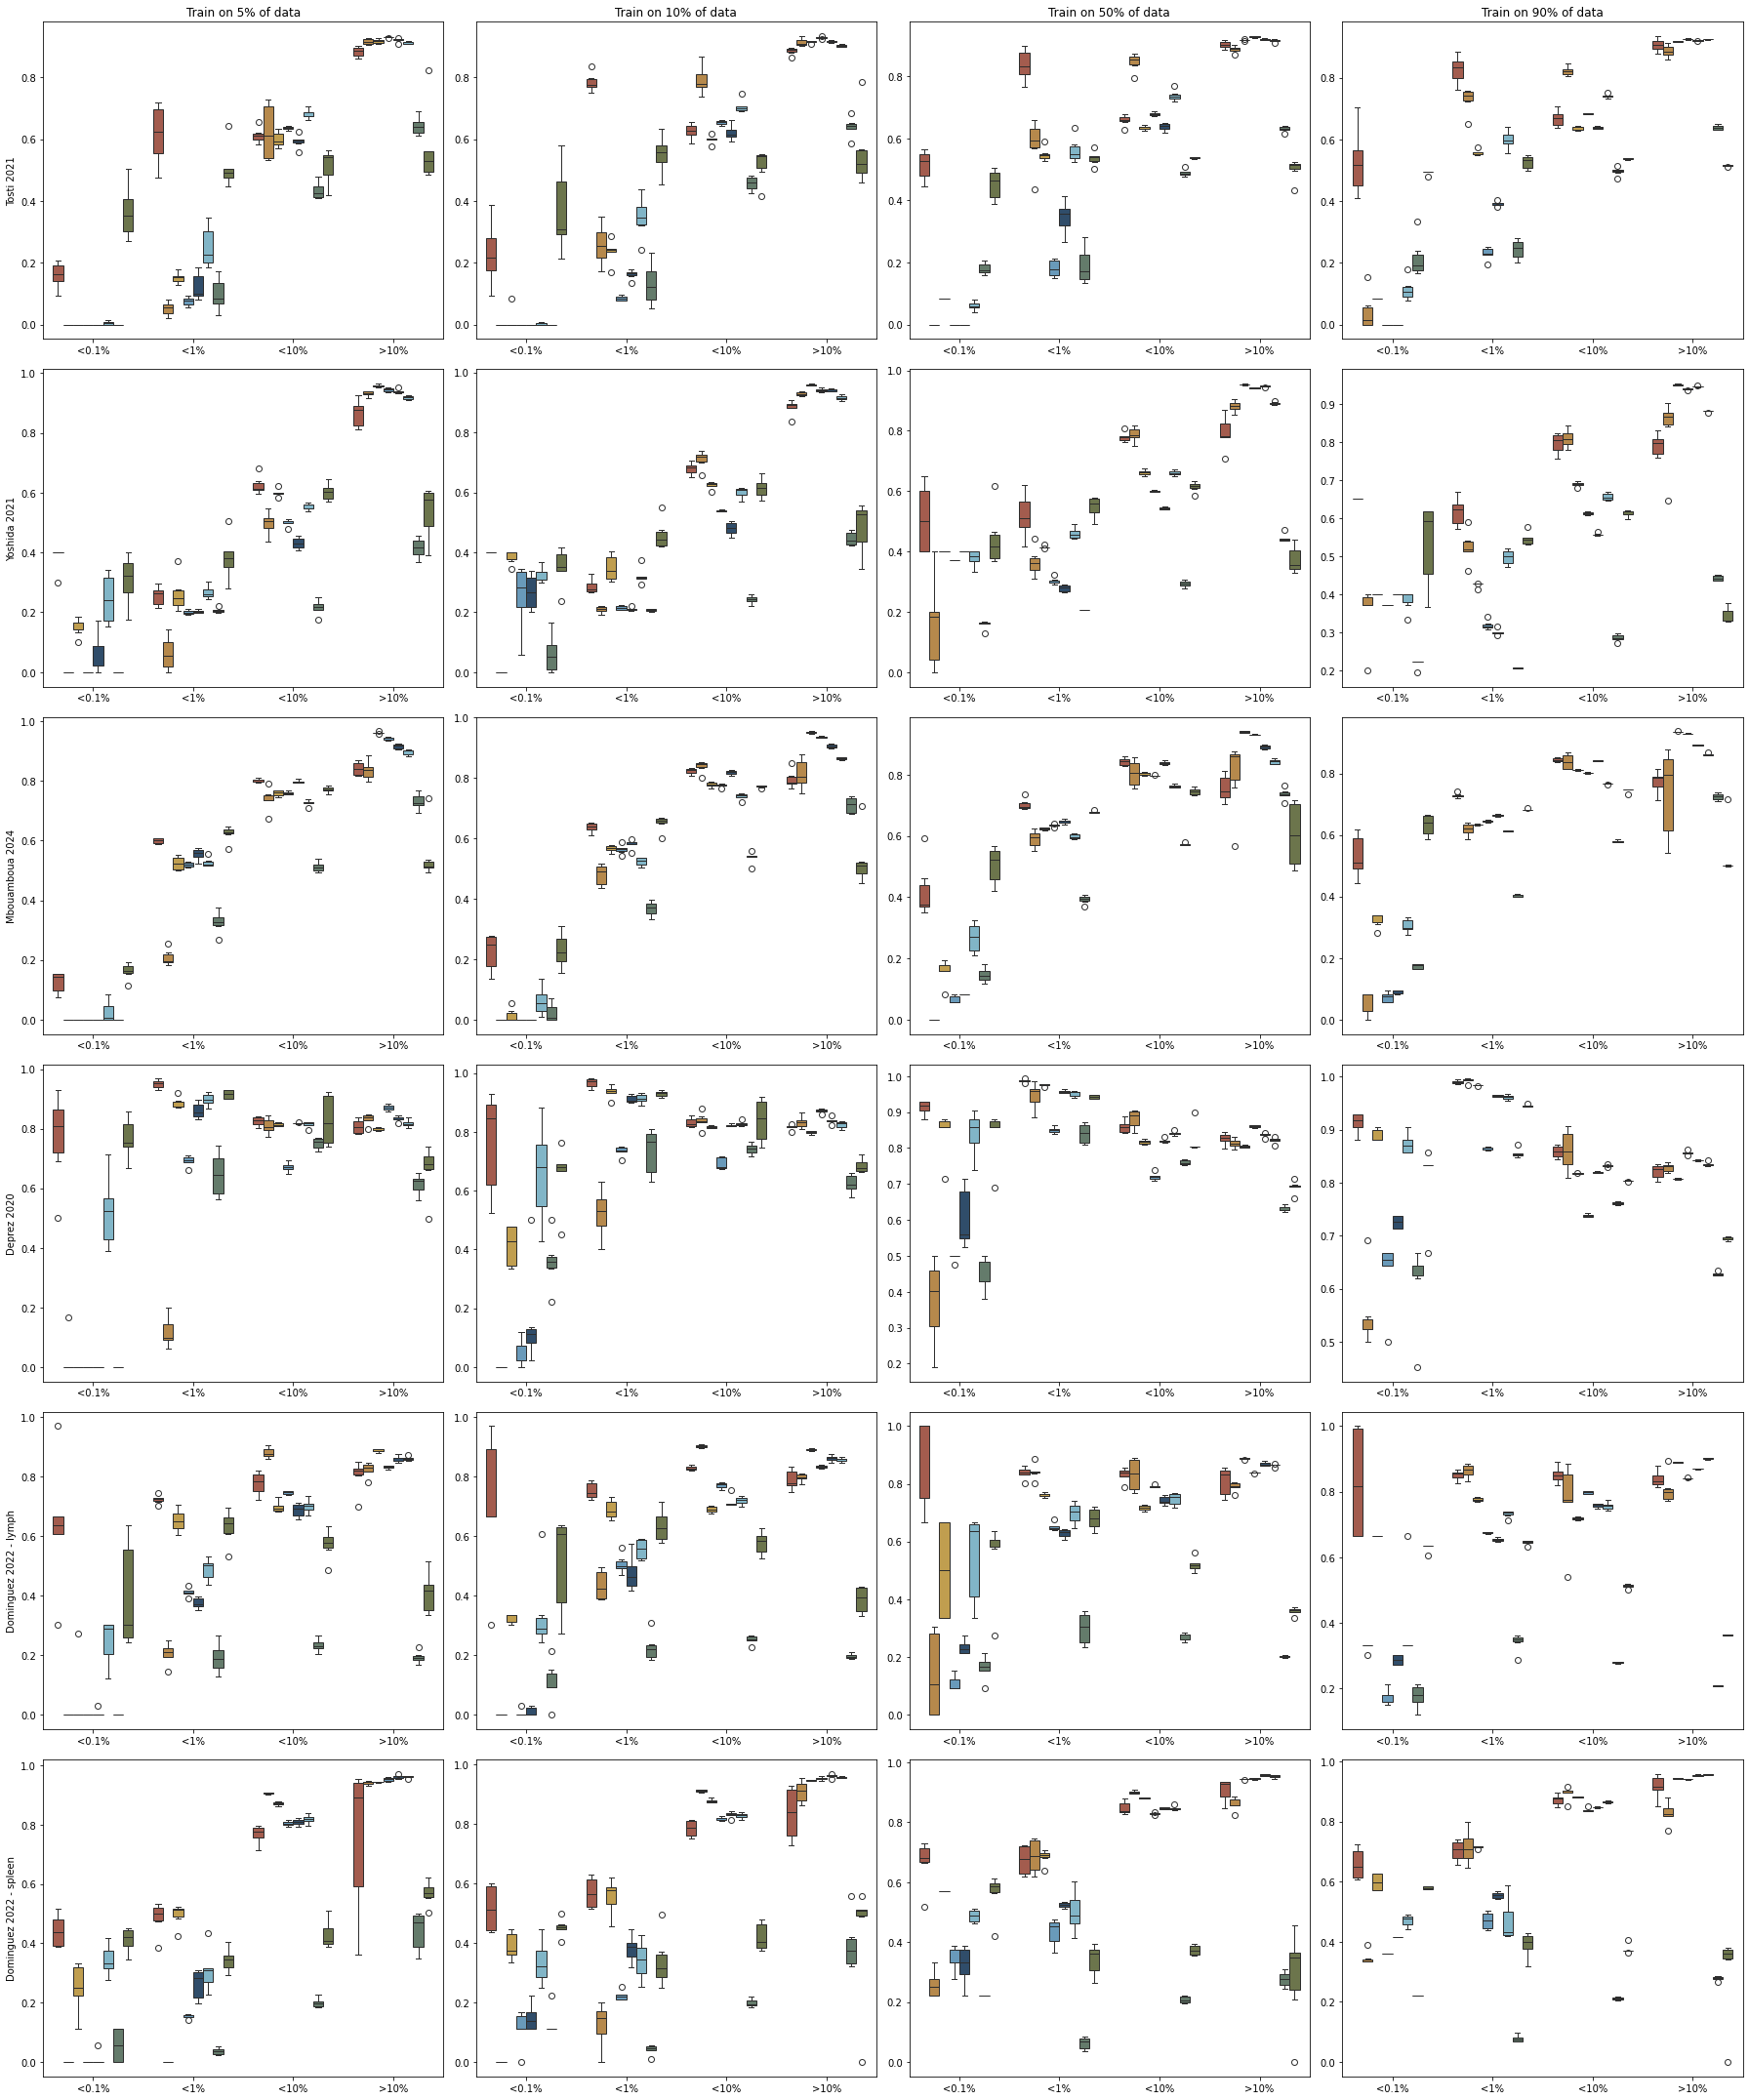

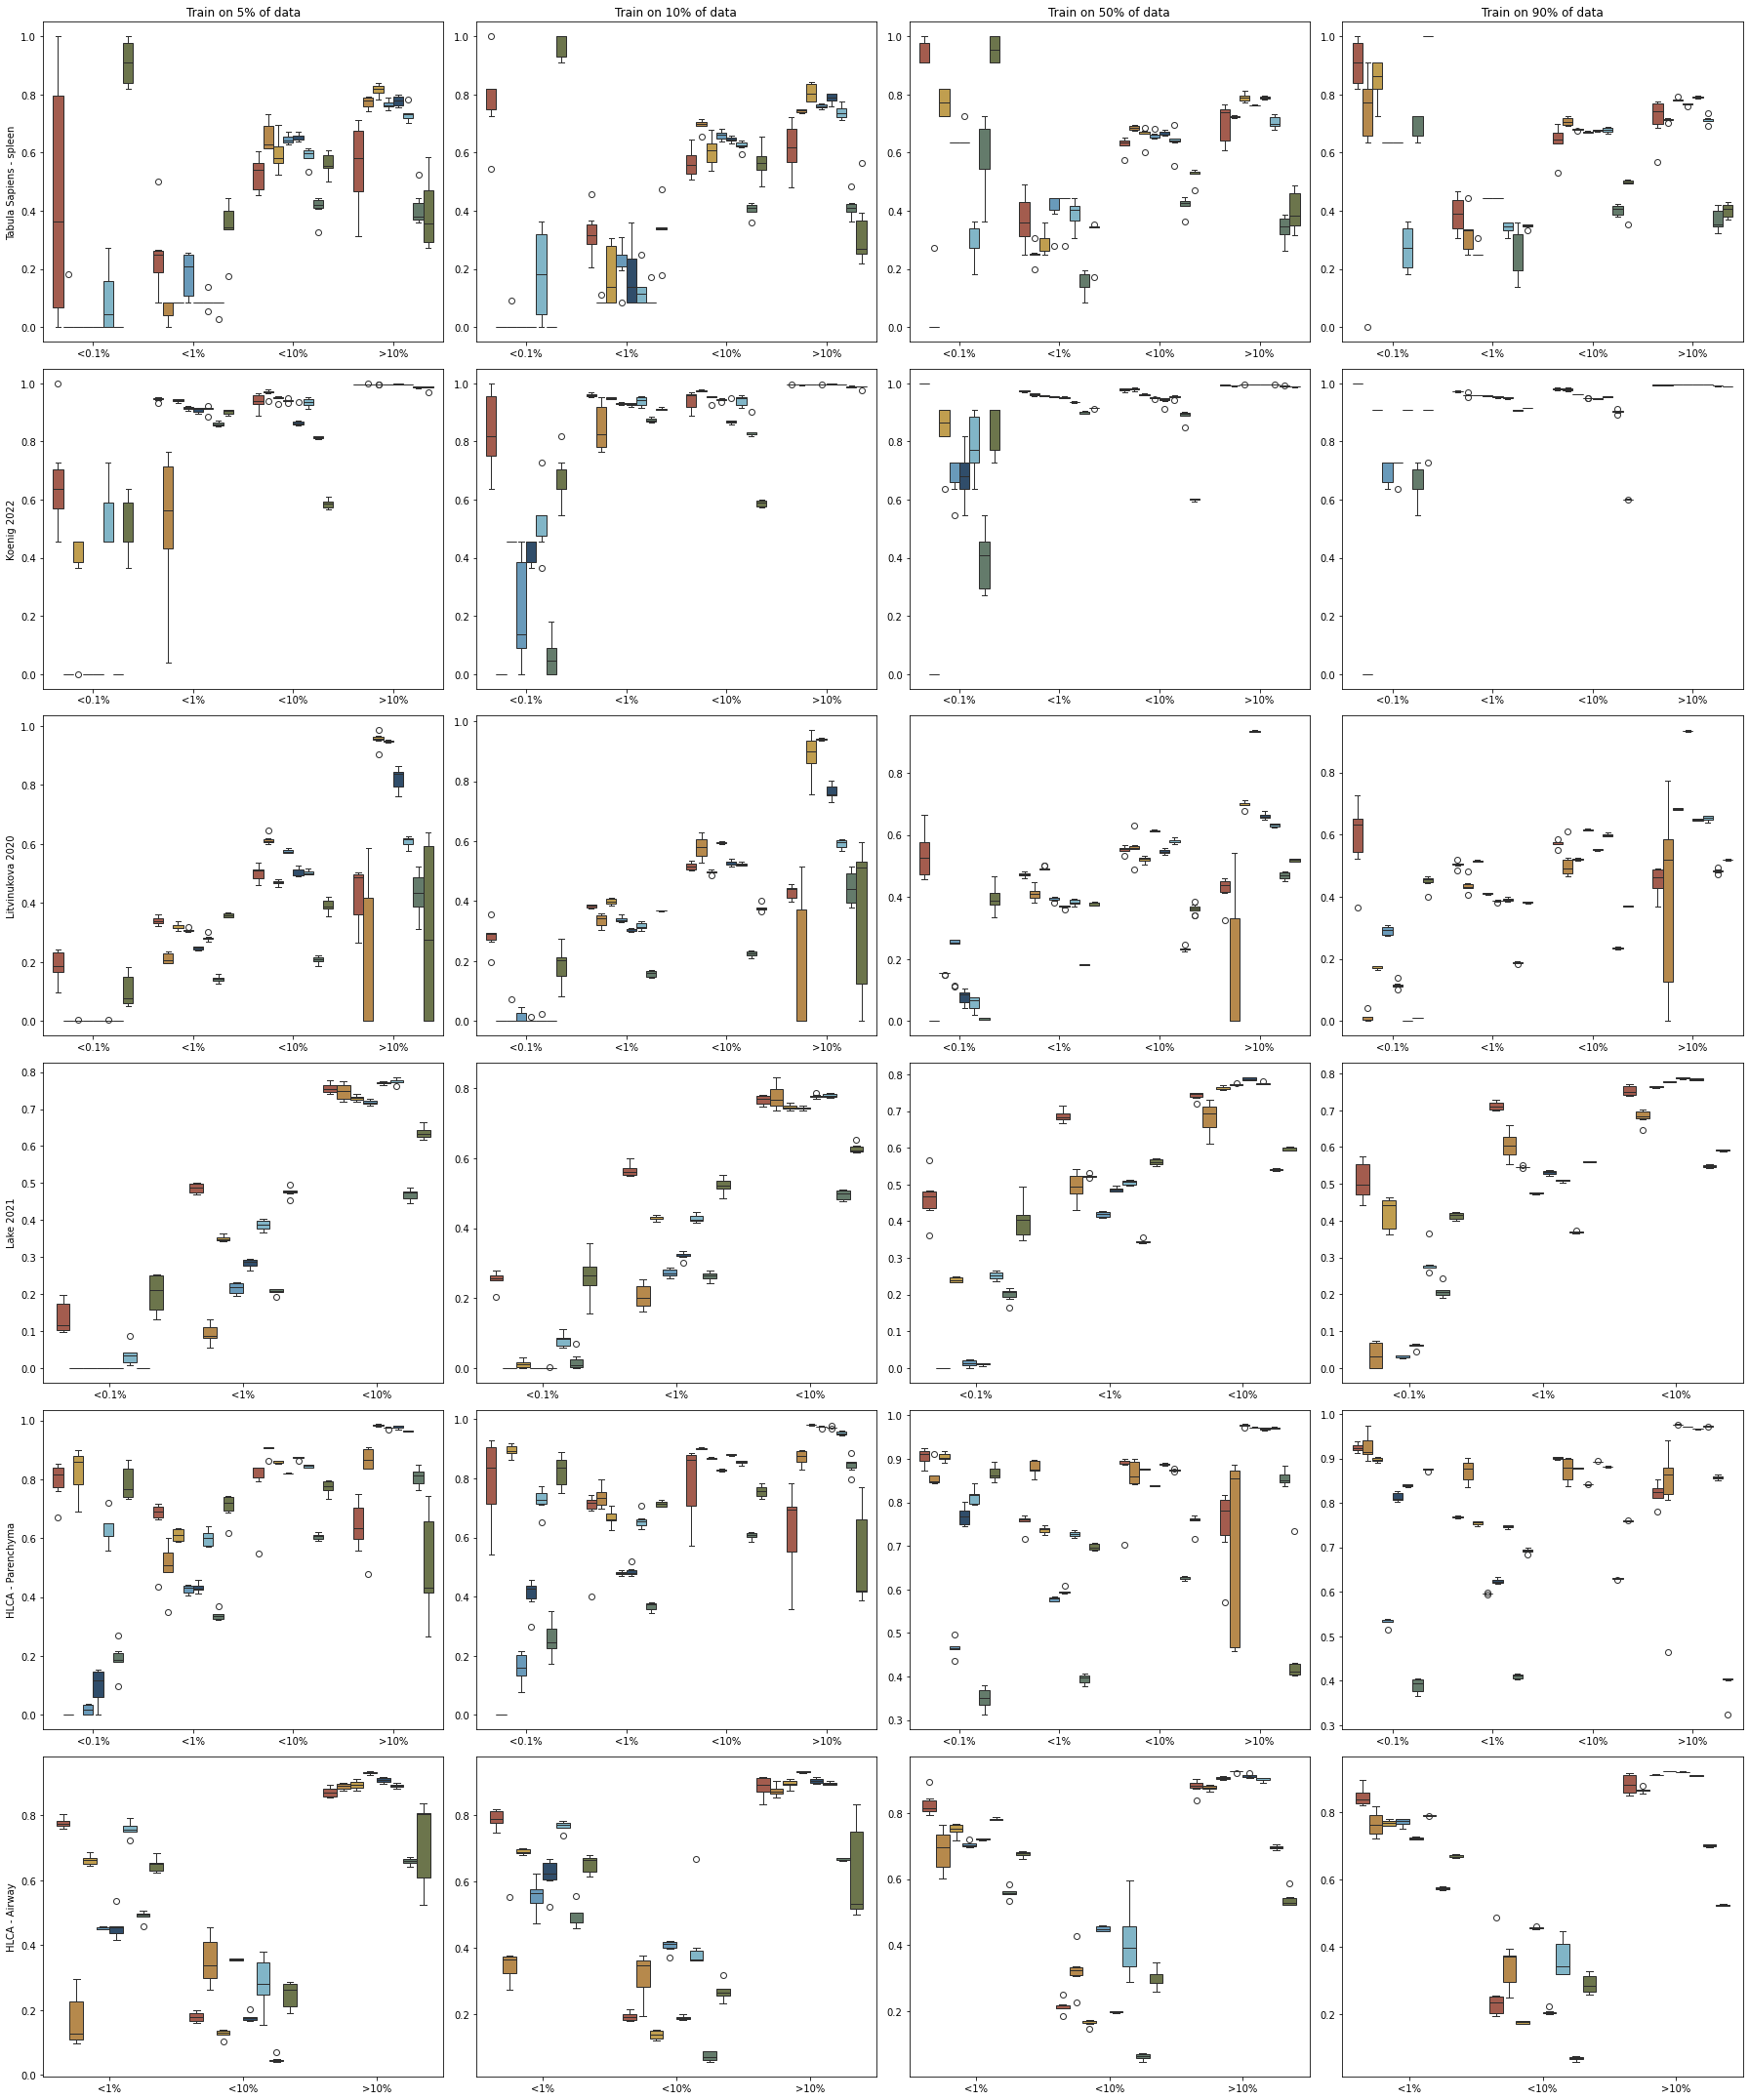

In [105]:
split = 'test'
met = 'balanced_acc'
show_legend = False
exclude_ds = []

ds = [i for v in diff_dict.values() for i in v]

for diff in diff_dict:
    if diff != 'dataset':
        print(f'--------- {diff} ---------')
        n_lines = max(len([ i for i in diff_dict[diff] if i not in exclude_ds]),2)
        f, axes = plt.subplots(n_lines, 4, figsize = (25,5*n_lines))
        i=0
            
        for dataset_name in diff_dict[diff]:
            if dataset_name not in exclude_ds:
                print(f'--------- {dataset_name} ---------')
                
                
                for j, pct_split in enumerate([0.05,0.1,0.5,0.9]):
                    bplot1 = axes[i,j]
                    
                    task_2 = runs_table_df.query("task == 'task_2'").query(f"dataset_name == '{dataset_name}'").query(f"test_fold_nb == {test_fold_selection[dataset_name]}").query(f'pct_split == {pct_split}')
            
                    task_2['dataset_name'] =task_2['dataset_name'].replace(aestetic_data_name)
                    task_2['model'] =task_2['model'].replace(aestetic_model_name)
                    
                    sub =task_2[['model', 'test_fold_nb',f'{split}_balanced_acc', f'{split}_xxsmall_balanced_acc',f'{split}_small_balanced_acc', f'{split}_medium_balanced_acc', f'{split}_large_balanced_acc']]
                    sub = pd.melt(sub, id_vars = 'model', value_vars = [f'{split}_xxsmall_balanced_acc',f'{split}_small_balanced_acc', f'{split}_medium_balanced_acc', f'{split}_large_balanced_acc'])
                    sub = sub.replace({f'{split}_xxsmall_balanced_acc' : '<0.1%',f'{split}_small_balanced_acc':'<1%', f'{split}_medium_balanced_acc':'<10%',f'{split}_large_balanced_acc':'>10%'})
            
                    
                    if dataset_name in ['tran_2021',aestetic_data_name['tran_2021'], 
                                        'hlca_trac_dataset_harmonized', aestetic_data_name['hlca_trac_dataset_harmonized']]:
                        ord =  ['<1%','<10%','>10%']
                    elif dataset_name in ['lake_2021', aestetic_data_name['lake_2021']]:
                        ord =  ['<0.1%','<1%','<10%']
                    else :
                        ord = ['<0.1%','<1%','<10%','>10%']
            
                    
                    sns.boxplot(x='variable',y ='value',hue = 'model',order = ord, hue_order = colors.keys(), data = sub,ax = bplot1, palette = sns.color_palette(colors.values()))
                    bplot1.tick_params(axis='x', rotation=0)
                    bplot1.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
                    
                    
                    if i != n_lines:
                        bplot1.set_xlabel('')
                    if i == n_lines:
                        bplot1.set_xlabel('Celltype size')
    
                    if j == 0:
                        bplot1.set_ylabel(aestetic_data_name[dataset_name])
                    else : 
                        bplot1.set_ylabel('')
                    if i == 0:
                        bplot1.set_title(f'Train on {pct_ticks[pct_split]} of data')
    
                    if not show_legend: 
                        bplot1.get_legend().set_visible(False)
                        
                i+=1
            plt.tight_layout()
            # f.suptitle(f'Balanced accuracy by celltype sizes') # in {aestetic_data_name[dataset_name]}')
            f.savefig(f'{fig_dir}task_2/by_size/prediction_boxplot_by_size_{diff}.png', transparent=False)


##  hue = pct_split - DEGRADE (NOT IN PAPER)

In [ ]:
split = 'test'
met = 'balanced_acc'
mode = 'box' #'box'
exclude_ds = ['litvinukova_2020']
show_legend = False
models = list(colors.keys())
n_models = len(models)
pct_values = list(pct_ticks.values())

pct_ticks = {0.05:'5%', 0.1:'10%', 0.5:'50%', 0.9:'90%'}
ticks = {0.05:0,0.1:1,0.5:2,0.9:3}
n_ticks = len(ticks)

for diff in diff_dict:
    if diff != 'dataset':
        print(f'--------- {diff} ---------')
        n_lines = max(len([ i for i in diff_dict[diff] if i not in exclude_ds]),2)
        f, axes = plt.subplots(n_lines, 2, figsize = (25,5*n_lines))
        i=0
        for dataset_name in diff_dict[diff]:
            if dataset_name not in exclude_ds:
                
                task_2 = runs_table_df.query("task == 'task_2'").query(f"dataset_name == '{dataset_name}'").query(f"test_fold_nb == {test_fold_selection[dataset_name]}")
                
                task_2['dataset_name'] =task_2['dataset_name'].replace(aestetic_data_name)
                task_2['model'] =task_2['model'].replace(aestetic_model_name)
                
                # task_2['model'] = pd.Categorical(task_2['model'], ['scPermut', 'scanvi', 'uce', 'pca_svm', 'harmony_svm', 'celltypist', 'scmap_cells', 'scmap_cluster']) 
                bplot1 = axes[i,0]
                bplot2 = axes[i,1]

                # # Création d'une palette pour chaque combinaison (model, pct)
                # palette = {}
                # for model, base_color in colors.items():
                #     shades = sns.light_palette(base_color, n_colors=n_ticks)
                #     for j, pct_split in enumerate(pct_ticks.values()):
                #         palette[(model, pct_split)] = shades[j]
                
                if mode == 'box':
                    # pct_split before model
                    # sns.boxplot(x = 'pct_split',y =f'{split}_{met}', hue = 'model', order = [0.05,0.1,0.5,0.9], hue_order = colors.keys(), data = task_2, ax = bplot1)

                    # model before pct_split
                    sns.boxplot(x = 'model',y =f'{split}_{met}', hue = 'pct_split', order = colors.keys(), hue_order = [0.05,0.1,0.5,0.9], data = task_2, ax = bplot1) 
                    
                    n_colors = len(colors)

                    box_patches = [p for p in bplot1.patches if isinstance(p, PathPatch

)]
                    for j, patch in enumerate(box_patches):
                        col = (str(list(colors.keys())[j%n_colors]),list(pct_ticks.values())[j//n_colors])
                        patch.set_facecolor(palette[col])
    
                
                # bplot1.set_xticks(list(ticks.values()), list(pct_ticks.values()))
                bplot1.tick_params(axis='x', rotation=0)
                if i == 0:
                    bplot1.set_title('Balanced accuracy on the test dataset')
                if i != n_lines:
                    bplot1.set_xlabel('')
                if i == n_lines:
                    bplot1.set_xlabel('Model')
                bplot1.set_ylabel(f'{aestetic_data_name[dataset_name]}') # - {diff} setup')
                bplot1.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)


                task_2['model'] = task_2['model'].replace({'Celltypist': 'PCA',
                           'scmap - cells': 'PCA',
                           'scmap - cluster': 'PCA'})
                colors_BE = {k:v for k, v in colors.items() if k not in ['Celltypist','scmap - cells','scmap - cluster']}
                # Création d'une palette pour chaque combinaison (model, pct)
                palette = {}
                for model, base_color in colors_BE.items():
                    shades = sns.light_palette(base_color, n_colors=n_ticks)
                    for j, pct_split in enumerate(pct_ticks.values()):
                        palette[(model, pct_split)] = shades[j]

                
                sns.boxplot(x = 'model',y =f'full_batch_mixing_entropy', hue = 'pct_split', order = colors_BE.keys(), hue_order = [0.05,0.1,0.5,0.9], data = task_2, ax = bplot2) 

                n_colors = len(colors_BE)
                
                box_patches = [p for p in bplot2.patches if isinstance(p, PathPatch)]
                for j, patch in enumerate(box_patches):
                    col = (str(list(colors_BE.keys())[j%n_colors]),list(pct_ticks.values())[j//n_colors])
                    patch.set_facecolor(palette[col])
                        
                bplot2.tick_params(axis='x', rotation=0)
                if i == 0:
                    bplot2.set_title('Batch mixing entropy the whole dataset')
                if i != n_lines:
                    bplot2.set_xlabel('')
                if i == n_lines:
                    bplot2.set_xlabel('Model')
                bplot2.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
                bplot2.set_ylabel('')
                
                if not show_legend: 
                    bplot1.get_legend().set_visible(False)
                    bplot2.get_legend().set_visible(False)
                    # bplot3.get_legend().set_visible(False)
                
                # f.suptitle(f'{dataset_name} - {diff} setup')
                i+=1
                # f.savefig(f'{fig_dir}task_2/prediction_boxplot_{diff}_{mode}.png', transparent=False)
                
                plt.tight_layout()

In [ ]:
split = 'test'
met = 'balanced_acc'
show_legend = False
exclude_ds = ['litvinukova_2020']

ds = [i for v in diff_dict.values() for i in v]

for diff in diff_dict:
    if diff != 'dataset':
        print(f'--------- {diff} ---------')
        n_lines = max(len([ i for i in diff_dict[diff] if i not in exclude_ds]),2)
        f, axes = plt.subplots(n_lines, 4, figsize = (25,5*n_lines))
        i=0
            
        for dataset_name in diff_dict[diff]:
            if dataset_name not in exclude_ds:
                print(f'--------- {dataset_name} ---------')
                
                
                for j, pct_split in enumerate([0.05,0.1,0.5,0.9]):
                    bplot1 = axes[i,j]
                    
                    task_2 = runs_table_df.query("task == 'task_2'").query(f"dataset_name == '{dataset_name}'").query(f"test_fold_nb == {test_fold_selection[dataset_name]}").query(f'pct_split == {pct_split}')
            
                    task_2['dataset_name'] =task_2['dataset_name'].replace(aestetic_data_name)
                    task_2['model'] =task_2['model'].replace(aestetic_model_name)
                    
                    sub =task_2[['model', 'test_fold_nb',f'{split}_balanced_acc', f'{split}_xxsmall_balanced_acc',f'{split}_small_balanced_acc', f'{split}_medium_balanced_acc', f'{split}_large_balanced_acc']]
                    sub = pd.melt(sub, id_vars = 'model', value_vars = [f'{split}_xxsmall_balanced_acc',f'{split}_small_balanced_acc', f'{split}_medium_balanced_acc', f'{split}_large_balanced_acc'])
                    sub = sub.replace({f'{split}_xxsmall_balanced_acc' : '<0.1%',f'{split}_small_balanced_acc':'<1%', f'{split}_medium_balanced_acc':'<10%',f'{split}_large_balanced_acc':'>10%'})
            
                    
                    if dataset_name in ['tran_2021',aestetic_data_name['tran_2021'], 
                                        'hlca_trac_dataset_harmonized', aestetic_data_name['hlca_trac_dataset_harmonized']]:
                        ord =  ['<1%','<10%','>10%']
                    elif dataset_name in ['lake_2021', aestetic_data_name['lake_2021']]:
                        ord =  ['<0.1%','<1%','<10%']
                    else :
                        ord = ['<0.1%','<1%','<10%','>10%']
            
                    palette = {}
                    for model, base_color in colors.items():
                        shades = sns.light_palette(base_color, n_colors=n_ticks)
                        for j, pct_split in enumerate(pct_ticks.values()):
                            palette[(model, pct_split)] = shades[j]
                    
                    sns.boxplot(x='model',y ='value',hue = 'variable',order = colors.keys(), hue_order =ord , data = sub,ax = bplot1)

                    n_colors = len(colors)
                
                    box_patches = [p for p in bplot1.patches if isinstance(p, PathPatchPatch.PathPatch)]
                    for j, patch in enumerate(box_patches):
                        col = (str(list(colors.keys())[j%n_colors]),list(pct_ticks.values())[j//n_colors])
                        patch.set_facecolor(palette[col])


                    
                    bplot1.tick_params(axis='x', rotation=0)
                    bplot1.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", borderaxespad=0)
                    
                    
                    if i != n_lines:
                        bplot1.set_xlabel('')
                    if i == n_lines:
                        bplot1.set_xlabel('Celltype size')
    
                    if j == 0:
                        bplot1.set_ylabel(aestetic_data_name[dataset_name])
                    else : 
                        bplot1.set_ylabel('')
                    # if i == 0:
                    #     bplot1.set_title(f'Train on {pct_ticks[pct_split]} of data')
    
                    if not show_legend: 
                        bplot1.get_legend().set_visible(False)
                        
                i+=1
            plt.tight_layout()
            # f.suptitle(f'Balanced accuracy by celltype sizes') # in {aestetic_data_name[dataset_name]}')
            # f.savefig(f'{fig_dir}task_2/by_size/prediction_boxplot_by_size_{diff}.png', transparent=False)


In [29]:
def plot_confusion_matrix(sub, sub_small, return_mat = False):
    # labels = list(set(np.unique(y_true)).union(set(np.unique(y_pred))))
    y_true = sub.obs['true']
    y_pred = sub.obs['pred']
    y_true_small = sub_small.obs['true']
    y_pred_small = sub_small.obs['pred']
    
    # true_labels = np.unique(y_true)
    # pred_labels = np.unique(y_pred)
    # true_labels_small = np.unique(y_true_small)
    # pred_labels_small = np.unique(y_pred_small)

    true_labels = y_true.value_counts().index[::-1]
    pred_labels = y_pred.value_counts().index[::-1]
    true_labels_small = y_true_small.value_counts().index[::-1]
    pred_labels_small = y_pred_small.value_counts().index[::-1]

    labels = sub.obs['true'].unique()
    cm = confusion_matrix(y_true, y_pred, labels = labels)
    cm_norm = cm / cm.sum(axis = 1, keepdims=True)
    cm_to_plot=pd.DataFrame(cm_norm, index = labels, columns=labels)
    cm_to_save=pd.DataFrame(cm, index = labels, columns=labels)
    
    cm_to_plot = cm_to_plot.fillna(value=0)
    cm_to_save = cm_to_save.fillna(value=0)
    
    size = len(labels)
    true_order = list(true_labels_small) + [i for i in cm_to_plot.columns if i not in true_labels_small]
    cm_to_plot = cm_to_plot.loc[true_labels_small,true_order]
    if return_mat:
        cm_to_save = cm_to_save.loc[true_labels_small,true_order]
        return cm_to_save, cm_to_plot
    f, ax = plt.subplots(figsize = (cm_to_plot.shape[1]/1.5, cm_to_plot.shape[0]/1.5))  #figsize=(size/1.5,size/1.5))
    sns.heatmap(cm_to_plot, annot=True,fmt='.2f', vmin = 0, vmax = 1)
    show_mask = np.asarray(cm_to_plot>0.01)
    for text, show_annot in zip(ax.texts, (element for row in show_mask for element in row)):
        text.set_visible(show_annot)

In [ ]:
plot_confusion_matrix(test_pred,test_pred)

In [44]:
def nan_to_0(val):
    if np.isnan(val) or pd.isna(val) or type(val) == type(None) :
        return 0.0
    else :
        return val
ID = 'BEN-4237'

y_full = load_pred(ID)
y_true_full = y_full['true']
split_full = y_full['split']
y_pred_full = y_full['pred']
print(ID)

ct_prop = y_true_full.value_counts() / y_true_full.value_counts().sum()

sizes = {'xxsmall' : list(ct_prop[ct_prop < 0.001].index), 
         'small': list(ct_prop[(ct_prop >= 0.001) & (ct_prop < 0.01)].index) ,
         'medium': list(ct_prop[(ct_prop >= 0.01) & (ct_prop < 0.1)].index),
         'large': list(ct_prop[ct_prop >= 0.1].index)}
metrics = {}
for group in ['train', 'test', 'val', 'full']:
    # print(group)
    if group != 'full':
        y_true = y_true_full.loc[split_full == group]
        y_pred = y_pred_full.loc[split_full == group]
    else :
        y_true = y_true_full
        y_pred = y_pred_full
    for s in sizes : 
        idx_s = np.isin(y_true, sizes[s]) # Boolean array, no issue to index y_pred
        y_true_sub = y_true[idx_s]
        y_pred_sub = y_pred[idx_s]
        # print(s)
        for metric in pred_metrics_list: 
            # print(metric)
            metrics[f"evaluation/{group}/{s}/{metric}"] = nan_to_0(pred_metrics_list[metric](y_true_sub, y_pred_sub))
            # print(nan_to_0(pred_metrics_list[metric](y_true_sub, y_pred_sub)))
        
        for metric in pred_metrics_list_balanced:
            # print(metric)
            # print(nan_to_0(pred_metrics_list_balanced[metric](y_true_sub, y_pred_sub)))
            metrics[f"evaluation/{group}/{s}/{metric}"] = nan_to_0(pred_metrics_list_balanced[metric](y_true_sub, y_pred_sub))


BEN-4237


/home/acollin/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/acollin/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/acollin/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/acollin/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/acollin/.local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:2399: UserWarning: y_pred contains classes not in y_true
  warnings.warn("y_pred contains classes not in y_true")
/home/acol

In [14]:

from scpermut.tools.clust_compute import nn_overlap, batch_entropy_mixing_score,lisi_avg, balanced_matthews_corrcoef, balanced_f1_score, balanced_cohen_kappa_score

from sklearn.metrics import accuracy_score,balanced_accuracy_score,matthews_corrcoef, f1_score,cohen_kappa_score, adjusted_rand_score, normalized_mutual_info_score, adjusted_mutual_info_score,davies_bouldin_score,adjusted_rand_score,confusion_matrix
f1_score = functools.partial(f1_score, average = 'macro')

from scpermut.workflow.dataset import load_dataset
from scpermut.tools.utils import ann_subset, check_raw,save_json, load_json, rgb2hex,hex2rgb
from tqdm import trange, tqdm
import warnings


def load_run_df():
    project = neptune.init_project(
            project="becavin-lab/benchmark",
        api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJiMmRkMWRjNS03ZGUwLTQ1MzQtYTViOS0yNTQ3MThlY2Q5NzUifQ==",
        mode="read-only",
            )# For checkpoint

    runs_table_df = project.fetch_runs_table().to_pandas()
    project.stop()

    f =  lambda x : x.replace('evaluation/', '').replace('parameters/', '').replace('/', '_')
    runs_table_df.columns = np.array(list(map(f, runs_table_df.columns)))
    return runs_table_df

def result_dir(neptune_id, working_dir = None):
    if working_dir :
        save_dir = working_dir + 'experiment_script/results/' + str(neptune_id) + '/'
    else :
        save_dir = './experiment_script/results/' + str(neptune_id) + '/'
    return save_dir
    
def load_pred(neptune_id, working_dir = None):
    save_dir = result_dir(neptune_id, working_dir)
    return pd.read_csv(save_dir + f'predictions_full.csv', index_col =0).squeeze()
    
pred_metrics_list = {'acc' : accuracy_score, 
                    'acc' : matthews_corrcoef,
                    'f1_score': f1_score,
                    'KPA' : cohen_kappa_score,
                    'ARI': adjusted_rand_score,
                    'NMI': normalized_mutual_info_score,
                    'AMI':adjusted_mutual_info_score}

pred_metrics_list_balanced = {'balanced_acc' : balanced_accuracy_score, 
                    'balanced_acc' : balanced_matthews_corrcoef,
                    'balanced_f1_score': balanced_f1_score,
                            'balanced_KPA' : balanced_cohen_kappa_score,
                            }

clustering_metrics_list = {#'clisi' : lisi_avg, 
                            'db_score' : davies_bouldin_score
                            }

batch_metrics_list = {'batch_mixing_entropy': batch_entropy_mixing_score}


# Figure 5 - Outperformance heatmap

In [10]:
runs_table_df = load_run_df("task_2")

https://app.neptune.ai/becavin-lab/benchmark/
Shutting down background jobs, please wait a moment...
Done!
Explore the metadata in the Neptune app:
https://app.neptune.ai/becavin-lab/benchmark/metadata


In [97]:
def est_croissante(liste):
    return all(liste[i] < liste[i + 1] for i in range(len(liste) - 1))


In [98]:
ds = [i for v in diff_dict.values() for i in v if i != 'tran_2021']

In [99]:
split = 'test'
met = 'balanced_acc'

ds = [i for v in diff_dict.values() for i in v if i not in ['tran_2021']]#,'litvinukova_2020']] #'hlca_par_dataset_harmonized'
# ds = [i for v in diff_dict.values() for i in v if i != 'tran_2021']

compare = pd.DataFrame(index = ds, columns = [i for i in aestetic_model_name.keys() if i not in ['scPermut', 'scPermut_default']])

for dataset_name in ds:
    print(f'--------- {dataset_name} ---------')
    task_2 = runs_table_df.query("task == 'task_2'").query(f"dataset_name == '{dataset_name}'").query(f"test_fold_nb == {test_fold_selection[dataset_name]}")
    print(task_2['model'].value_counts())
    mean_acc = pd.pivot_table(task_2, values=f'{split}_{met}', index='model', columns='pct_split', aggfunc='mean')
    outperf = pd.Series(index=mean_acc.index).drop('scPermut')

    for model in outperf.index:
        best_acc = mean_acc.loc[model,0.9]
        scperm_acc = mean_acc.loc['scPermut',:] > best_acc
        if scperm_acc.any():
            outperf.loc[model] = scperm_acc[scperm_acc].index[0]
        else :
            outperf.loc[model] = 1
        compare.loc[dataset_name,:] = outperf
compare = compare.astype(float)

--------- tosti_2021 ---------
scPermut         24
scanvi           24
uce              24
celltypist       24
harmony_svm      24
pca_svm          24
scmap_cluster    24
scmap_cells      24
Name: model, dtype: int64


/tmp/ipykernel_242227/4175880111.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')
/tmp/ipykernel_242227/4175880111.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')


--------- yoshida_2021 ---------
scanvi           24
scPermut         24
uce              24
celltypist       24
harmony_svm      24
pca_svm          24
scmap_cluster    24
scmap_cells      24
Name: model, dtype: int64
--------- htap ---------
scPermut         24
uce              24
celltypist       24
harmony_svm      24
pca_svm          24
scmap_cluster    24
scmap_cells      24
scanvi           24
Name: model, dtype: int64
--------- ajrccm_by_batch ---------
scanvi           24
scPermut         24
uce              24
celltypist       24
harmony_svm      24
pca_svm          24
scmap_cluster    24
scmap_cells      24
Name: model, dtype: int64
--------- dominguez_2022_lymph ---------


/tmp/ipykernel_242227/4175880111.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')
/tmp/ipykernel_242227/4175880111.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')


scPermut         24
scanvi           24
uce              24
celltypist       24
harmony_svm      24
pca_svm          24
scmap_cluster    24
scmap_cells      24
Name: model, dtype: int64
--------- dominguez_2022_spleen ---------
scPermut         24
scanvi           24
uce              24
celltypist       24
harmony_svm      24
pca_svm          24
scmap_cluster    24
scmap_cells      24
Name: model, dtype: int64
--------- tabula_2022_spleen ---------


/tmp/ipykernel_242227/4175880111.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')
/tmp/ipykernel_242227/4175880111.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')


scPermut         24
scanvi           24
uce              24
celltypist       24
harmony_svm      24
pca_svm          24
scmap_cluster    24
scmap_cells      24
Name: model, dtype: int64
--------- koenig_2022 ---------
scPermut         24
scanvi           24
uce              24
celltypist       24
harmony_svm      24
pca_svm          24
scmap_cluster    24
scmap_cells      24
Name: model, dtype: int64
--------- litvinukova_2020 ---------


/tmp/ipykernel_242227/4175880111.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')
/tmp/ipykernel_242227/4175880111.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')


uce              27
celltypist       27
harmony_svm      27
pca_svm          27
scmap_cluster    27
scmap_cells      27
scanvi           24
scPermut         24
Name: model, dtype: int64
--------- lake_2021 ---------
scPermut         24
scanvi           24
uce              24
celltypist       24
harmony_svm      24
pca_svm          24
scmap_cluster    24
scmap_cells      24
Name: model, dtype: int64
--------- hlca_par_dataset_harmonized ---------


/tmp/ipykernel_242227/4175880111.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')
/tmp/ipykernel_242227/4175880111.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')


scanvi           24
uce              24
celltypist       24
harmony_svm      24
scmap_cluster    24
pca_svm          24
scmap_cells      24
scPermut         22
Name: model, dtype: int64
--------- hlca_trac_dataset_harmonized ---------


/tmp/ipykernel_242227/4175880111.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')


scanvi           24
uce              24
celltypist       24
scPermut         24
harmony_svm      24
pca_svm          24
scmap_cluster    24
scmap_cells      24
Name: model, dtype: int64


/tmp/ipykernel_242227/4175880111.py:14: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  outperf = pd.Series(index=mean_acc.index).drop('scPermut')


In [100]:
compare = compare.replace({0.05:5,0.1:4,0.5:3,0.9:2, 1:1}).astype(int)

In [101]:
compare = compare.rename(columns = aestetic_model_name, index = aestetic_data_name)

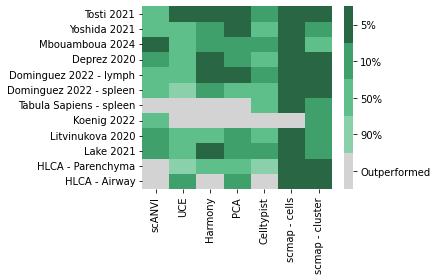

In [40]:
# colors = ["#296644","#3A9262", "#50B97F",  "#7CCB9F", "lightgray"]
# ticks = ["5%","10%","50%","90%",'Outperformed']

colors = ['lightgray', '#8AD0AA', '#5FBF8A', '#40A06B', '#296644']
ticks = ['Outperformed', '90%', '50%', '10%', '5%']
# colors = ["#04ff00","#28e525","#2ac327","#2aa328","lightgray"]
import matplotlib.colors as mcolors
import matplotlib as mpl 
cmap = mcolors.LinearSegmentedColormap.from_list("my_palette", colors)
cmap = mpl.colors.ListedColormap(colors)
vmap = {i: v for i,v in enumerate(ticks)}
n = len(vmap)

ax = sns.heatmap(compare, cmap = cmap) # 1-compare is a trick to have the bar in the correct order

colorbar = ax.collections[0].colorbar
# The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
colorbar.set_ticklabels(list(vmap.values()))
plt.tight_layout()
ax.get_figure().savefig(f'{fig_dir}task_2/comparison_heatmap.png', transparent=False,dpi = 100)


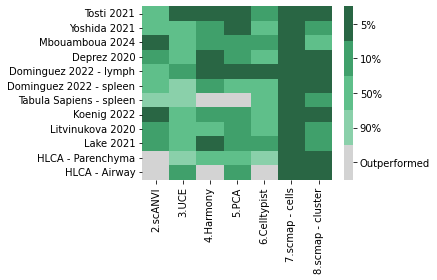

In [102]:
# colors = ["#296644","#3A9262", "#50B97F",  "#7CCB9F", "lightgray"]
# ticks = ["5%","10%","50%","90%",'Outperformed']

colors = ['lightgray', '#8AD0AA', '#5FBF8A', '#40A06B', '#296644']
ticks = ['Outperformed', '90%', '50%', '10%', '5%']
# colors = ["#04ff00","#28e525","#2ac327","#2aa328","lightgray"]
import matplotlib.colors as mcolors
import matplotlib as mpl 
cmap = mcolors.LinearSegmentedColormap.from_list("my_palette", colors)
cmap = mpl.colors.ListedColormap(colors)
vmap = {i: v for i,v in enumerate(ticks)}
n = len(vmap)

ax = sns.heatmap(compare, cmap = cmap) # 1-compare is a trick to have the bar in the correct order

colorbar = ax.collections[0].colorbar
# The list comprehension calculates the positions to place the labels to be evenly distributed across the colorbar
r = colorbar.vmax - colorbar.vmin
colorbar.set_ticks([colorbar.vmin + 0.5 * r / (n) + r * i / (n) for i in range(n)])
colorbar.set_ticklabels(list(vmap.values()))
plt.tight_layout()
ax.get_figure().savefig(f'{fig_dir}task_2/comparison_heatmap.png', transparent=False,dpi = 100)


# Probability output (NOT IN PAPER)

Plot the output probability of the predictor for each cell

In [23]:
def result_dir(neptune_id, working_dir = None):
    if working_dir :
        save_dir = working_dir + 'experiment_script/results/' + str(neptune_id) + '/'
    else :
        save_dir = './experiment_script/results/' + str(neptune_id) + '/'
    return save_dir
    
def load_confusion_matrix(neptune_id,train_split= 'val', working_dir = None):
    save_dir = result_dir(neptune_id, working_dir)
    return pd.read_csv(save_dir + f'confusion_matrix_{train_split}.csv', index_col =0)

def load_pred(neptune_id, working_dir = None):
    save_dir = result_dir(neptune_id, working_dir)
    return pd.read_csv(save_dir + f'predictions_full.csv', index_col =0).squeeze()

def load_proba_pred(neptune_id, working_dir = None):
    save_dir = result_dir(neptune_id, working_dir)
    p = save_dir + f'y_pred_proba_full.csv'
    if os.path.exists(p):
        return pd.read_csv(save_dir + f'y_pred_proba_full.csv', index_col =0).squeeze()
    else :
        return None
def load_split(neptune_id, working_dir = None):
    save_dir = result_dir(neptune_id, working_dir)
    return pd.read_csv(save_dir + f'split_full.csv', index_col =0).squeeze()
    
def load_latent_space(neptune_id, working_dir = None):
    save_dir = result_dir(neptune_id, working_dir)
    return np.load(save_dir + f'latent_space_full.npy')

def load_umap(neptune_id, working_dir = None):
    save_dir = result_dir(neptune_id, working_dir)
    return np.load(save_dir + f'umap_full.npy')

def load_expe(neptune_id, working_dir='/home/acollin/scPermut/'):
    save_dir = result_dir(neptune_id, working_dir)
    X = load_latent_space(neptune_id, working_dir)
    pred = load_pred(neptune_id, working_dir)
    adata = sc.AnnData(X = X, obs = pred)
    proba_pred = load_proba_pred(neptune_id, working_dir)
    umap = load_umap(neptune_id, working_dir)
    if not proba_pred is None :
        adata.obsm['proba_pred'] = proba_pred
    adata.obsm['X_umap'] = umap
    adata.obs['pred'] = pd.Categorical(adata.obs['pred'])
    adata.obs['true'] = pd.Categorical(adata.obs['true'])
    return adata

def plot_umap_proba(adata, celltype, **kwargs):
    adata.obs[celltype] = adata.obsm['proba_pred'][celltype]
    sc.pl.umap(adata, color = celltype, **kwargs)


def plot_size_conf_correlation(adata):
    proba_pred = adata.obsm['proba_pred']
    class_df_dict = {ct : proba_pred.loc[adata.obs['true'] == ct, :] for ct in adata.obs['true'].cat.categories} # The order of the plot is defined here (adata.obs['true_louvain'].cat.categories)
    mean_acc_dict = {ct : df.mean(axis = 0) for ct, df in class_df_dict.items()}

    f, axes = plt.subplots(1,2, figsize = (10,5))
    f.suptitle('correlation between confidence and class size')
    pd.Series({ct : class_df_dict[ct].shape[0] for ct in mean_acc_dict.keys()}).plot.bar(ax = axes[0])
    pd.Series({ct : mean_acc_dict[ct][ct] for ct in mean_acc_dict.keys()}).plot.bar(ax =axes[1])

import math

def plot_class_confidence(adata, mode='box', layout = True, **kwargs):
    '''
    mode is either bar (average) or box (boxplot)
    '''
    proba_pred = adata.obsm['proba_pred']

    # y_pred_raw = y_pred_raw[adata.obs[true_key].cat.categories]
    class_df_dict = {ct : proba_pred.loc[adata.obs['true'] == ct, :] for ct in adata.obs['true'].cat.categories}
    mean_acc_dict = {ct : df.mean(axis = 0) for ct, df in class_df_dict.items()}

    n = math.ceil(np.sqrt(len(adata.obs['true'].cat.categories)))

    f, axes = plt.subplots(n,n, constrained_layout=layout)
#     plt.constrained_layout()
    i = 0
    for ct, df in class_df_dict.items():
        r = i // n
        c = i % n
        ax = axes[r,c]
        if mode == 'box':
            df.plot.box(ax = ax, figsize = (20,15), ylim = (-0.01,1.01), **kwargs) #, xlabel = adata.obs['true'].cat.categories
        if mode == 'bar':
            df = mean_acc_dict[ct]
            df.plot.bar(ax = ax, figsize = (20,15), ylim = (0,1), **kwargs)
        ax.tick_params(axis='x', labelrotation=90 )
        ax.set_title(ct + f'- {class_df_dict[ct].shape[0]} cells')
        i+=1


def plot_class_accuracy(adata, layout = True, **kwargs):
    '''
    mode is either bar (average) or box (boxplot)
    '''
    labels = adata.obs['true'].cat.categories
    conf_mat = pd.DataFrame(confusion_matrix(adata.obs['true'], adata.obs['pred'], labels=labels),index = labels, columns = labels)

    n = math.ceil(np.sqrt(len(labels)))
    f, axes = plt.subplots(n,n, constrained_layout=layout)
    f.suptitle("Accuracy & confusion by celltype")
#     plt.constrained_layout()
    i = 0
    for ct in labels:
        r = i // n
        c = i % n
        ax = axes[r,c]
        df = conf_mat.loc[ct,:]/conf_mat.loc[ct,:].sum()  
        df.plot.bar(ax = ax, figsize = (20,15), ylim = (0,1), **kwargs)
        ax.tick_params(axis='x', labelrotation=90 )
        ax.set_title(ct + f'- {conf_mat.loc[ct,:].sum()} cells')
        i+=1

In [155]:
ad = load_expe('BEN-8693')

In [179]:
ad.obs['proba_true'] = pd.Series()


/tmp/ipykernel_156561/2018196143.py:1: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  ad.obs['proba_true'] = pd.Series()


In [183]:
for ct in ad.obs['true'].unique():
    sub = ad[ad.obs['true'] == ct]
    ad.obs['proba_true'].loc[sub.obs.index] = ad.obsm['proba_pred'].loc[sub.obs.index, ct]

/tmp/ipykernel_156561/2187143882.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ad.obs['proba_true'].loc[sub.obs.index] = ad.obsm['proba_pred'].loc[sub.obs.index, ct]


/home/acollin/.conda/envs/scanpy_recent/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


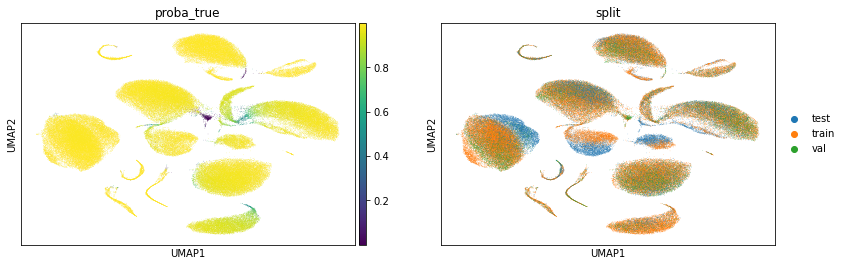

In [187]:
sc.pl.umap(ad, color = ['proba_true', 'split'])

/home/acollin/.conda/envs/scanpy_recent/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


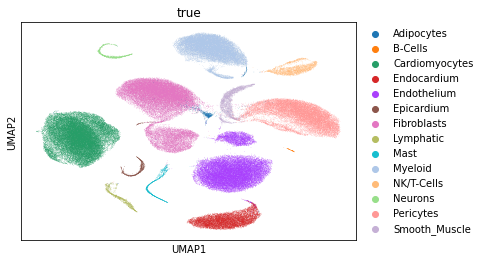

In [166]:
sc.pl.umap(ad,color = 'true')

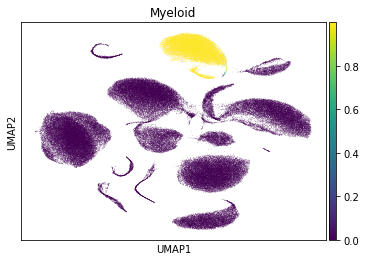

In [170]:
plot_umap_proba(ad, 'Myeloid')

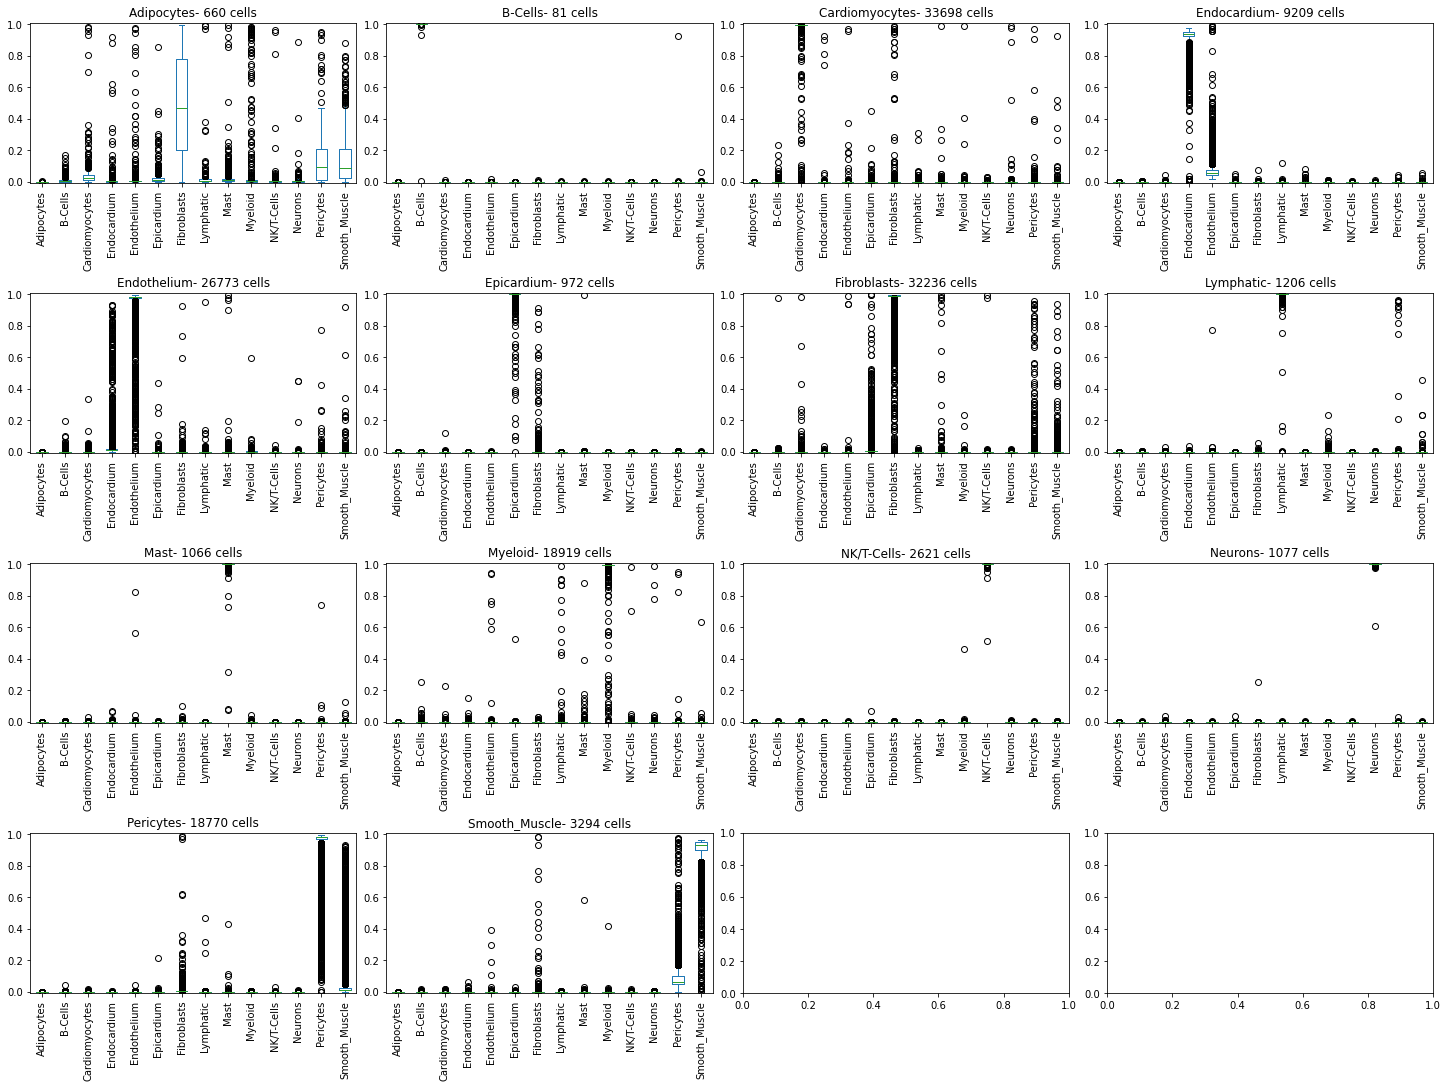

In [158]:
plot_class_confidence(ad)